### Philadelphia Crime Data
Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import glob
import copy
import datetime
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Importing Data
the data provided can be found at https://www.opendataphilly.org/

In [2]:
glob.glob("*")
os.chdir('C:/Users/princ/Downloads')

In [3]:
df=pd.read_csv("crime.csv")

#### Checking Data
First we check the size of the dataset and the features presenta 
afterwards we check the type of variables of each feature and if they are indeed what they should be. 
As a safety measure we also look into how many uncomplete (nan) data we have on each feature. 
Finally we start pre processing the dataframe: correcting values, discarding whats not used, and making it easier to work with.

In [4]:
print (df.shape, '\n\n', df.columns, '\n\n', df.ftypes)

(2191142, 14) 

 Index(['Dc_Dist', 'Psa', 'Dispatch_Date_Time', 'Dispatch_Date',
       'Dispatch_Time', 'Hour', 'Dc_Key', 'Location_Block', 'UCR_General',
       'Text_General_Code', 'Police_Districts', 'Month', 'Lon', 'Lat'],
      dtype='object') 

 Dc_Dist                 int64:dense
Psa                    object:dense
Dispatch_Date_Time     object:dense
Dispatch_Date          object:dense
Dispatch_Time          object:dense
Hour                    int64:dense
Dc_Key                  int64:dense
Location_Block         object:dense
UCR_General           float64:dense
Text_General_Code      object:dense
Police_Districts      float64:dense
Month                  object:dense
Lon                   float64:dense
Lat                   float64:dense
dtype: object


In [5]:
for i in df.columns:
    print (i, df[i][1], round(len(df[df[i].isnull()])/float(len(df)),2))

Dc_Dist 14 0.0
Psa 1 0.0
Dispatch_Date_Time 2009-05-10 00:55:00 0.0
Dispatch_Date 2009-05-10 0.0
Dispatch_Time 00:55:00 0.0
Hour 0 0.0
Dc_Key 200914033994 0.0
Location_Block 8500 BLOCK MITCH 0.0
UCR_General 2600.0 0.0
Text_General_Code All Other Offenses 0.0
Police_Districts nan 0.01
Month 2009-05 0.0
Lon nan 0.01
Lat nan 0.01


only 1% of data NaN at "Police_Districts", disconsidering that data. 
also, we have some repeated information and other features that might not be relevant for a first analysis, discarding those. 
Finally, properly formating feature names and data.

In [6]:
DF = copy.deepcopy(df[[u'Dc_Dist', u'Dispatch_Date', u'Dispatch_Time', u'Text_General_Code', u'Lon', u'Lat']])

for i in DF.columns:
    
    DF=DF[DF[i].isnull()==False]

DF.columns = [u'DISTRICT', u'DATE', u'TIME', u'CAUSE', u'LON', u'LAT']
DF.index=np.arange(len(DF))
DF['TIME'] = DF['TIME'].apply(lambda x: datetime.datetime.strptime(x,'%H:%M:%S').time())
DF['DATE']=pd.to_datetime(DF['DATE'])
DF['COUNT']=np.ones(len(DF))

YRMN=min(DF['DATE'].dt.year)
YRMX=min(DF['DATE'].dt.year)

DF['MTH_COUNT']=DF['DATE'].dt.month+(DF['DATE'].dt.year-YRMN)*12

DF.head(5)

DISTRICT       DATE      TIME               CAUSE        LON        LAT  \
0        35 2009-07-19  01:09:00   Weapon Violations -75.130477  40.036389   
1         9 2009-06-25  00:14:00  All Other Offenses -75.166350  39.969532   
2        17 2015-04-25  12:50:00              Thefts -75.166412  39.940070   
3        23 2009-02-10  14:33:00      Other Assaults -75.171149  39.979586   
4        22 2015-10-06  18:18:00              Thefts -75.160229  39.976134   

   COUNT  MTH_COUNT  
0    1.0         43  
1    1.0         42  
2    1.0        112  
3    1.0         38  
4    1.0        118

#### Ploting and first step analysis

#### Plotting graph for Top 7 crimes from 2006 to 2016

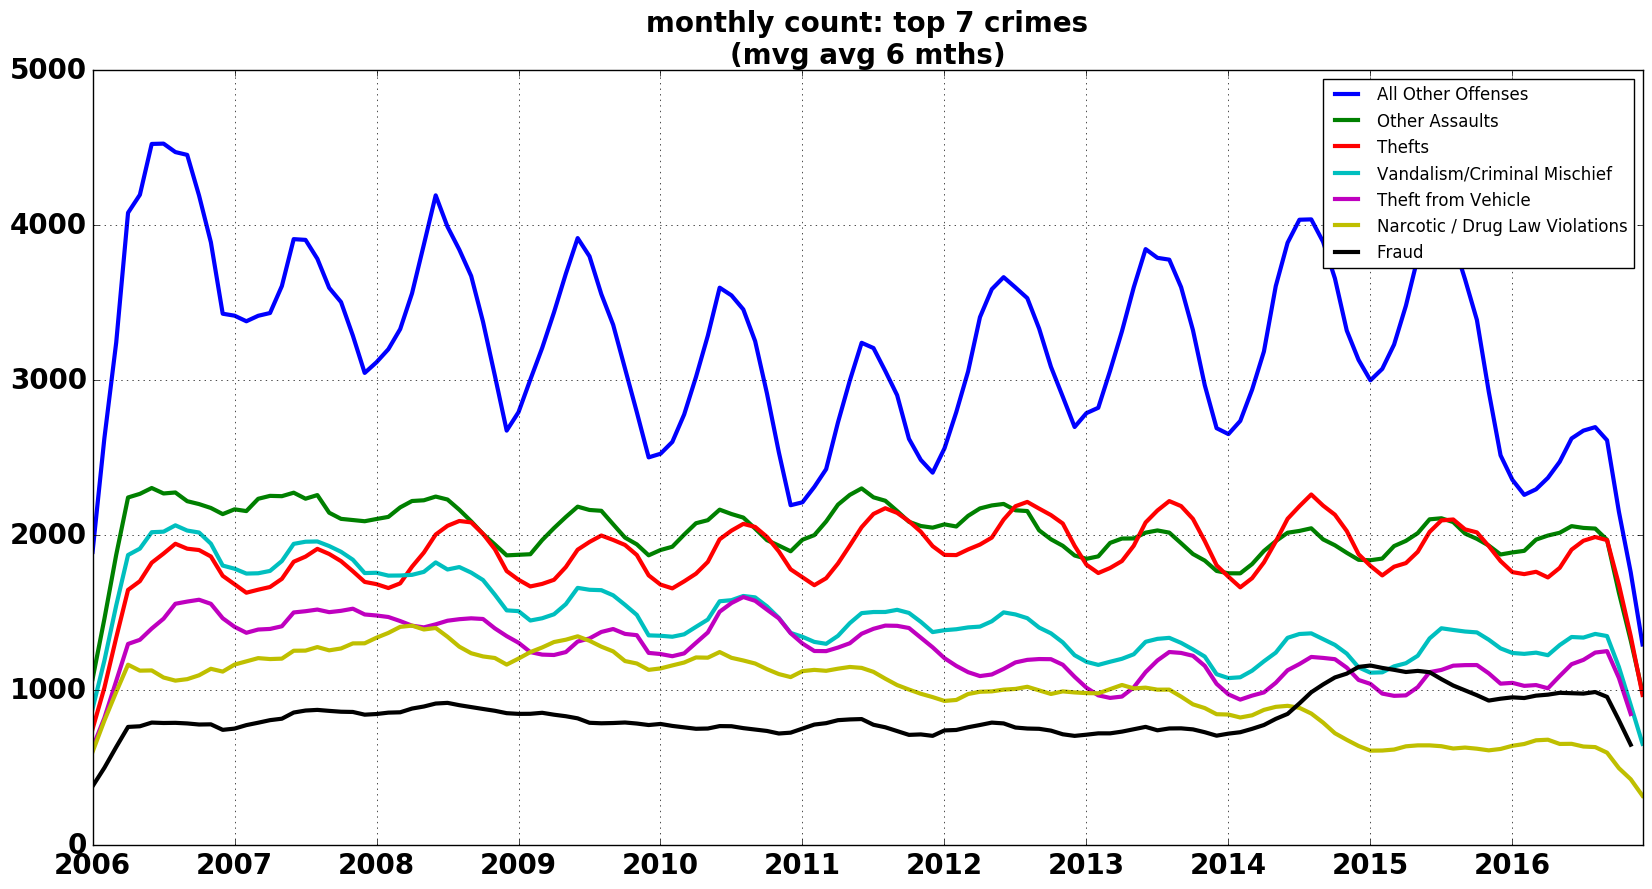

In [7]:
text_opts={'fontsize':20,'fontweight':'bold'}

interval=11

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
size=7

causes = DF.groupby('CAUSE')['COUNT'].count().sort_values(ascending=False)[:size].index

plt.figure(figsize=(20,10))

handle=[]

for i in causes:
    
    dummy_df = DF[DF['CAUSE']==i] 
    
    dummy_by_date = dummy_df.groupby('MTH_COUNT')['COUNT'].sum().reset_index()
    
#     plt.plot_date(dummy_by_date['MTH_COUNT'],dummy_by_date['COUNT'], '-', linewidth=5)
    plt.plot_date(dummy_by_date['MTH_COUNT'],movingaverage(dummy_by_date['COUNT'],6), '-', linewidth=3)
    
    handle=handle+['%s' %i]
    
plt.legend(handle)


xmin=min(dummy_df['MTH_COUNT'])
xmax=max(dummy_df['MTH_COUNT'])

plt.xticks(np.arange(xmin,xmax+1,12), np.arange((interval), dtype=int)+2006, **text_opts)

plt.yticks(**text_opts)
plt.grid()
plt.title('monthly count: top %d crimes\n(mvg avg 6 mths)' %size, **text_opts)

#### PLotting graph for Top 5 Districts with crime from 2006 to 2016

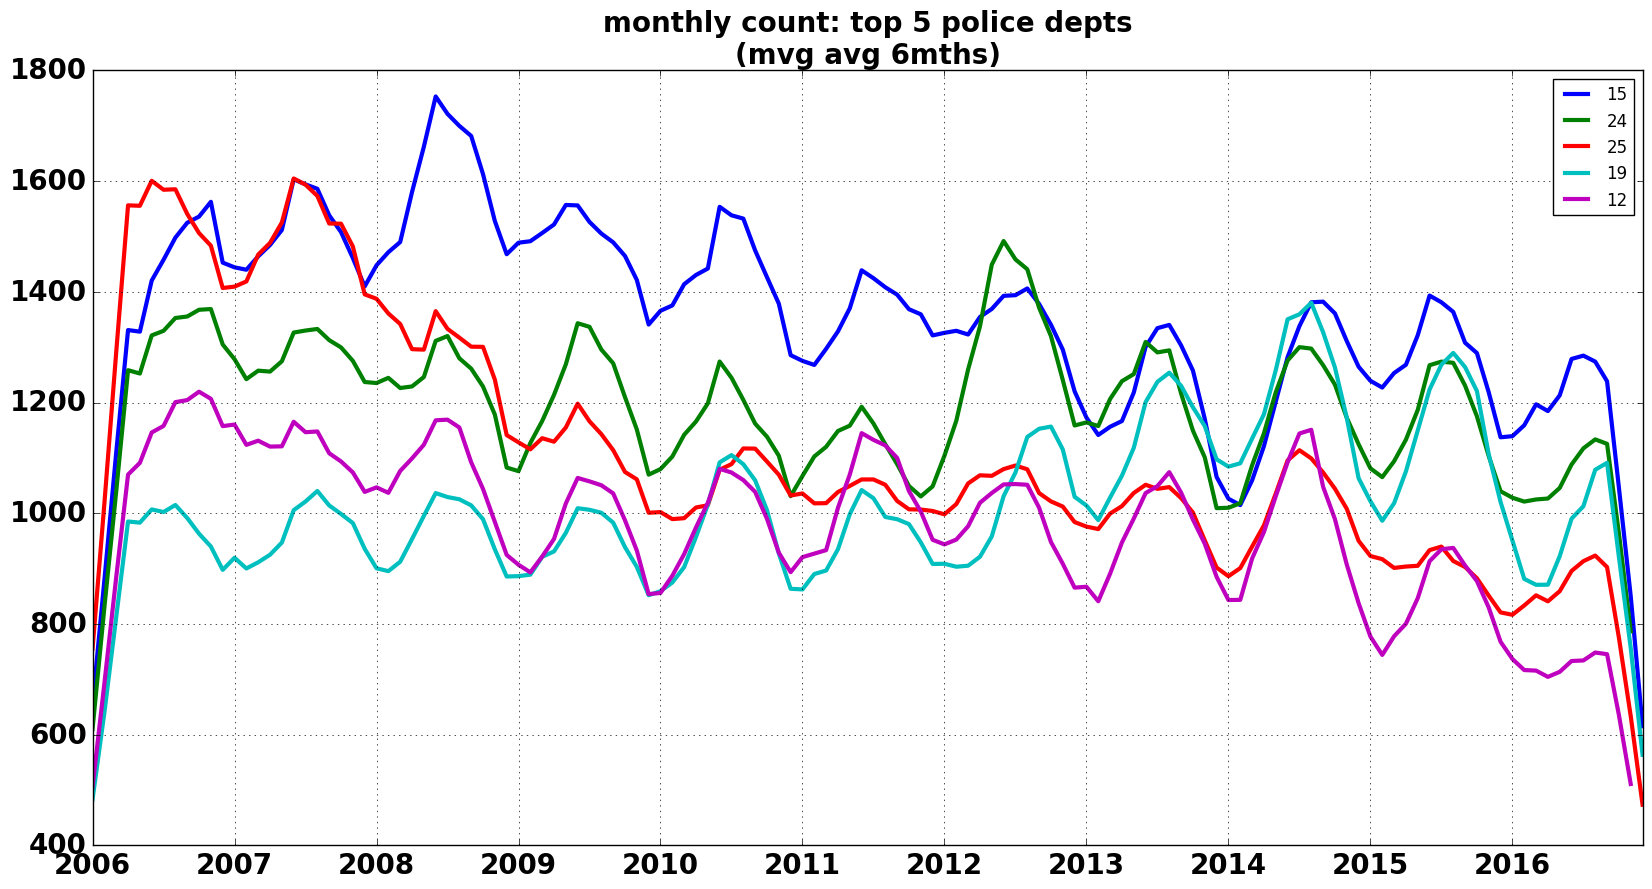

In [8]:
size=5

pds = DF.groupby('DISTRICT')['COUNT'].count().sort_values(ascending=False)[:size].index

plt.figure(figsize=(20,10))

handle=[]

for i in pds:
    
    dummy_df = DF[DF['DISTRICT']==i] 
    
    dummy_by_date = dummy_df.groupby('MTH_COUNT')['COUNT'].sum().reset_index()
    
    #plt.plot_date(dummy_by_date['MTH_COUNT'],dummy_by_date['COUNT'])
    
    plt.plot_date(dummy_by_date['MTH_COUNT'],movingaverage(dummy_by_date['COUNT'],6), '-', linewidth=3)
    
    handle=handle+['%s' %i]
    
plt.legend(handle)

xmin=min(dummy_df['MTH_COUNT'])
xmax=max(dummy_df['MTH_COUNT'])

plt.xticks(np.arange(xmin,xmax+1,12), np.arange((interval), dtype=int)+2006, **text_opts)

plt.yticks(**text_opts)
plt.grid()
plt.title('monthly count: top %d police depts\n(mvg avg 6mths)' %size, **text_opts)

#### Plotting graph individually for all the crime from 2006 to 2016

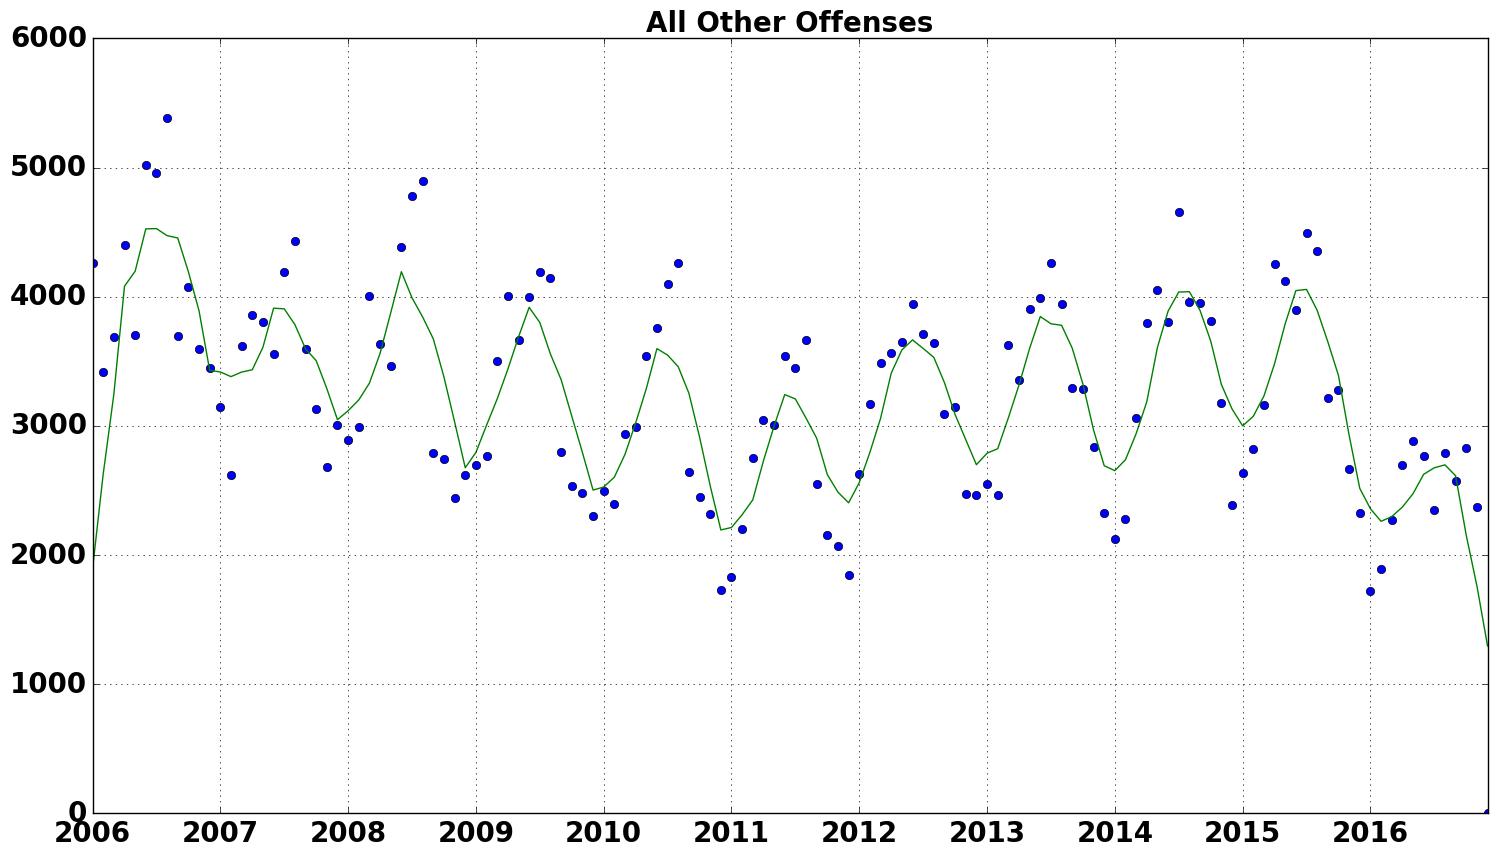

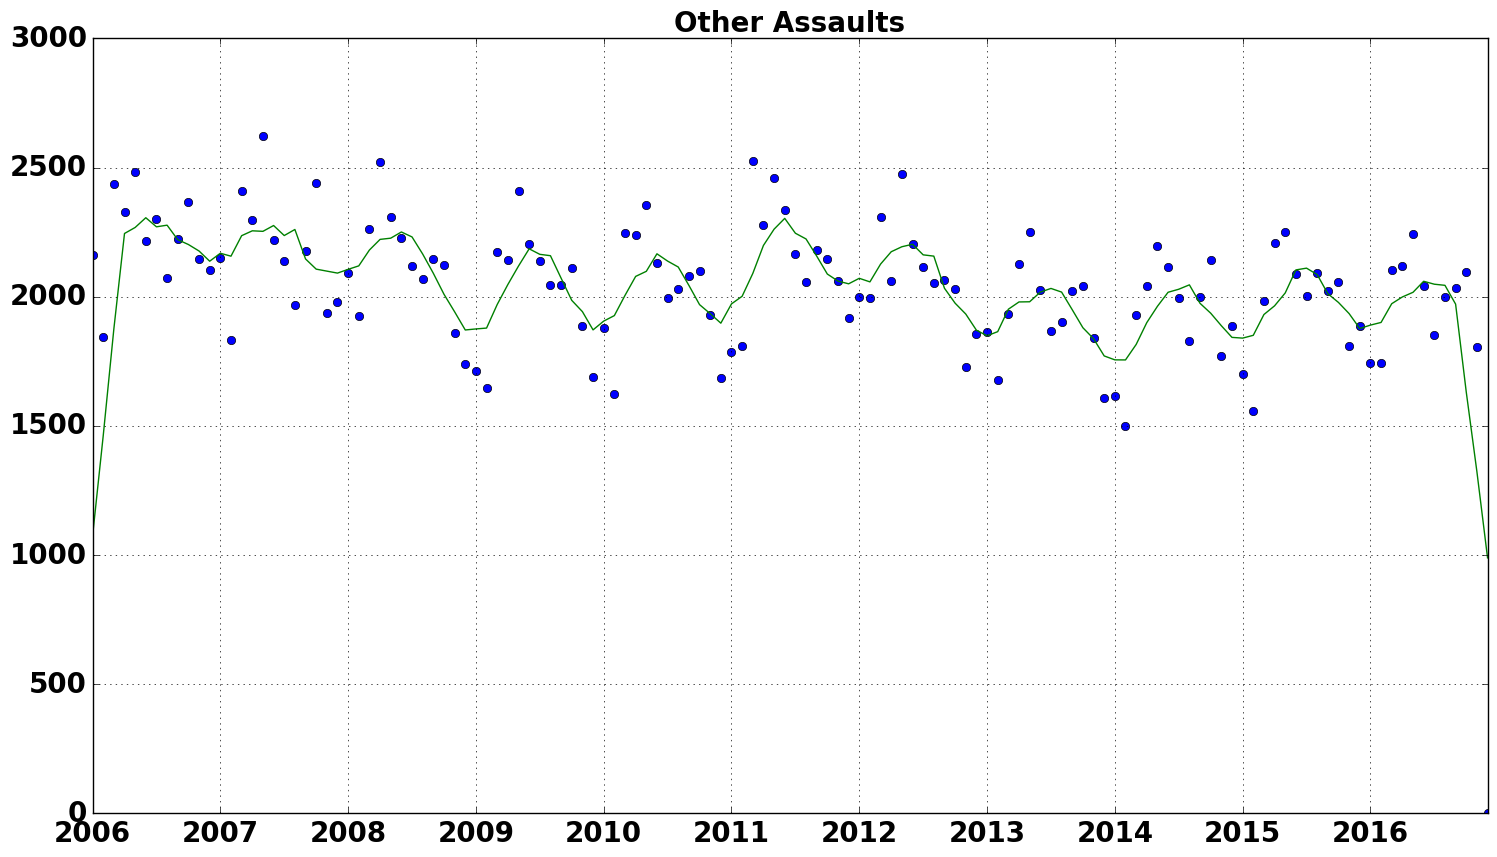

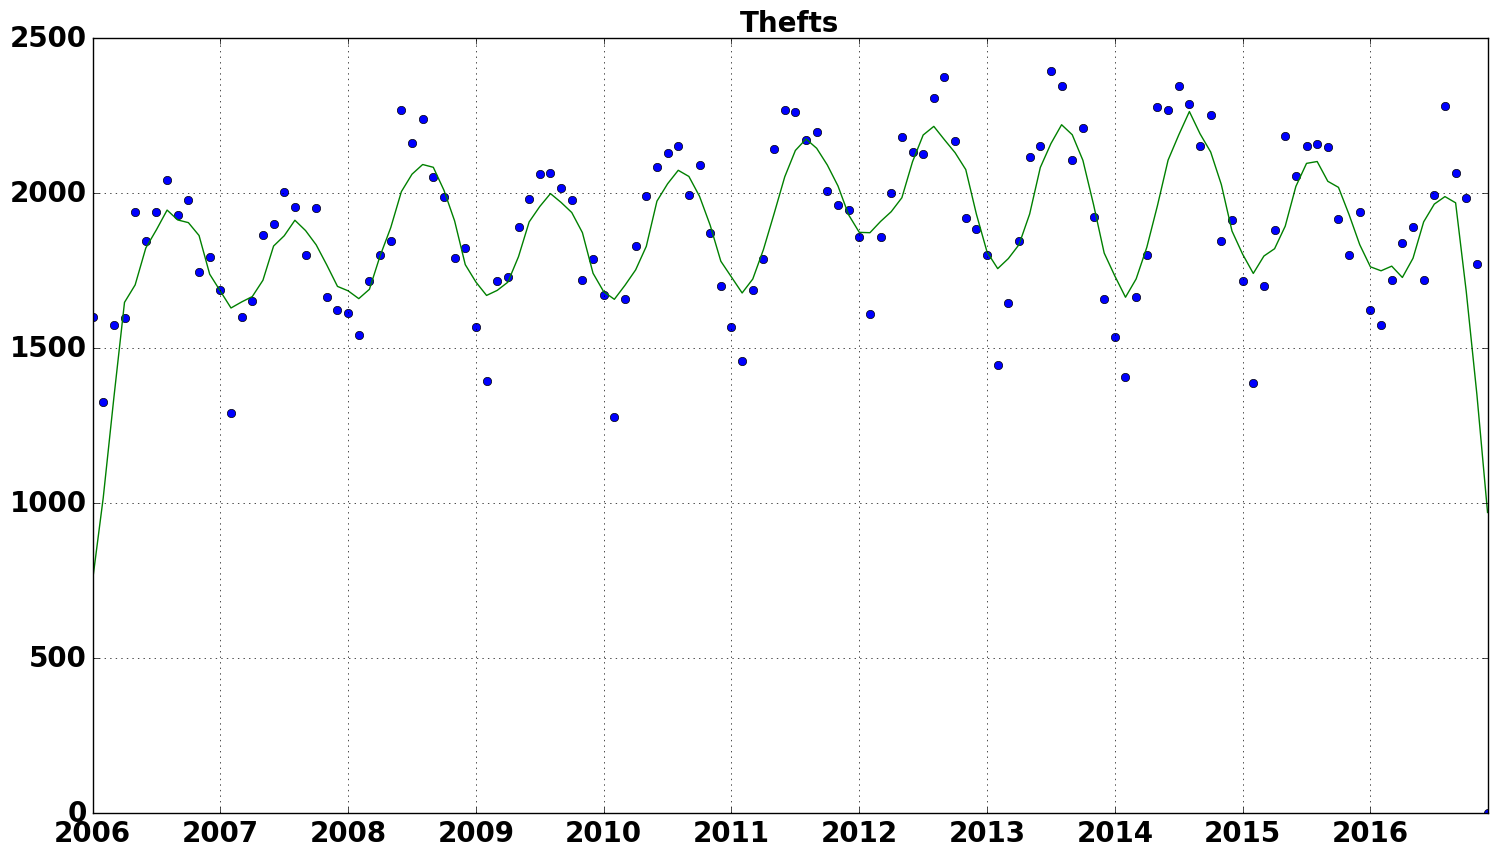

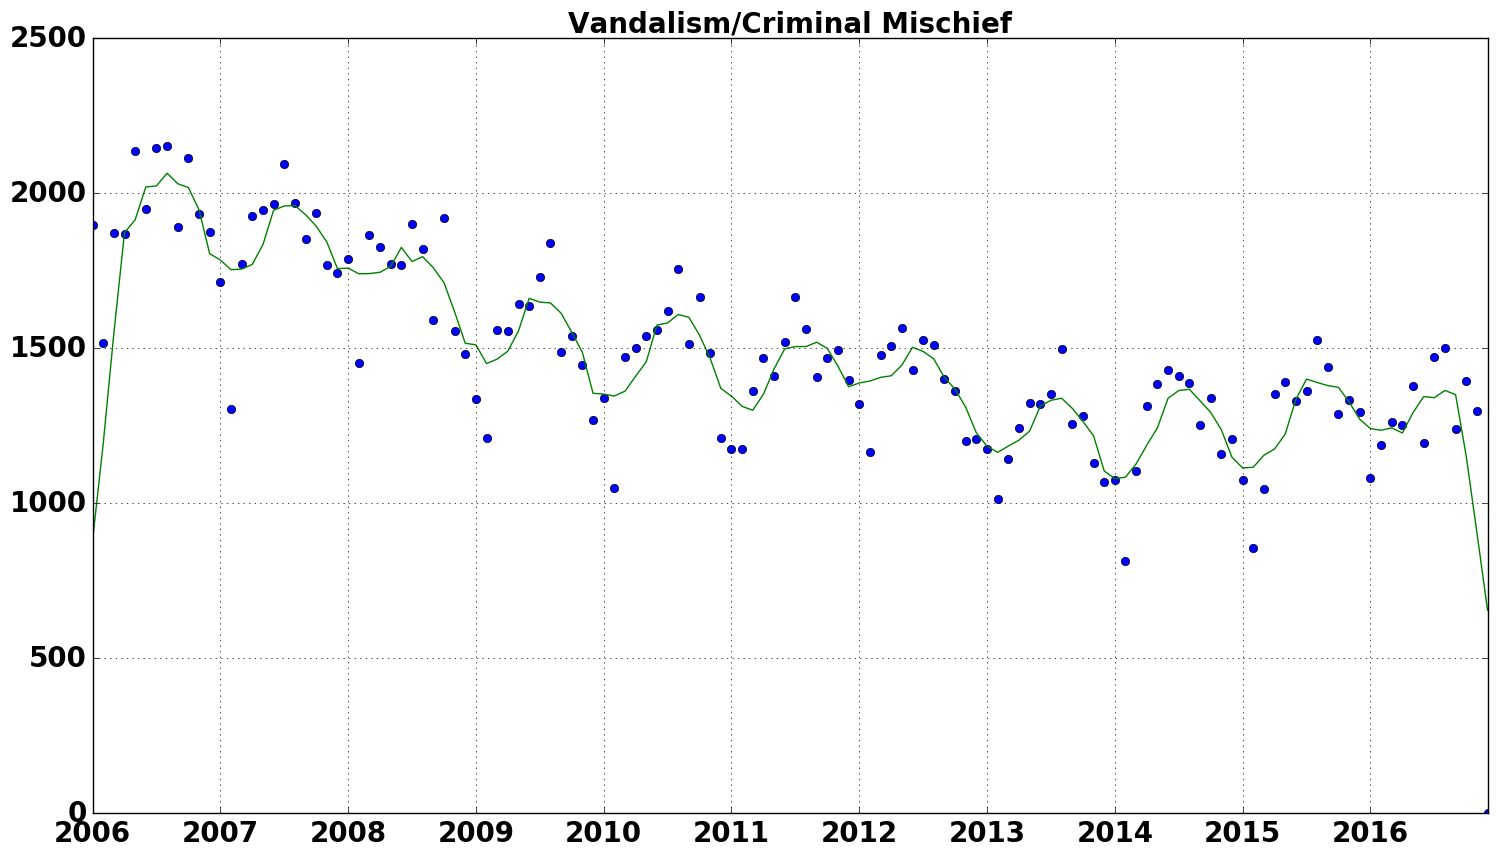

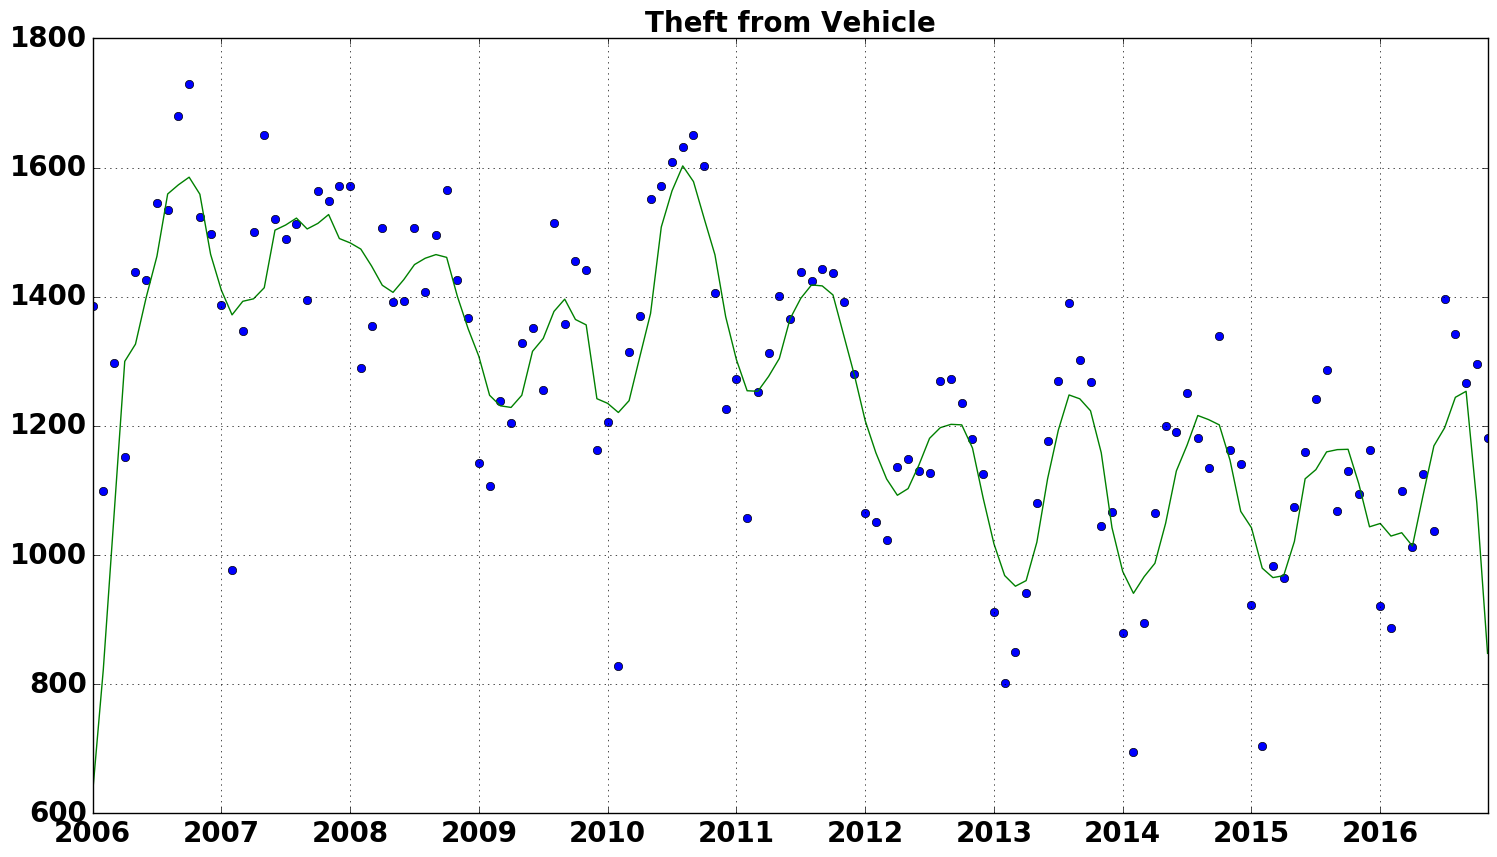

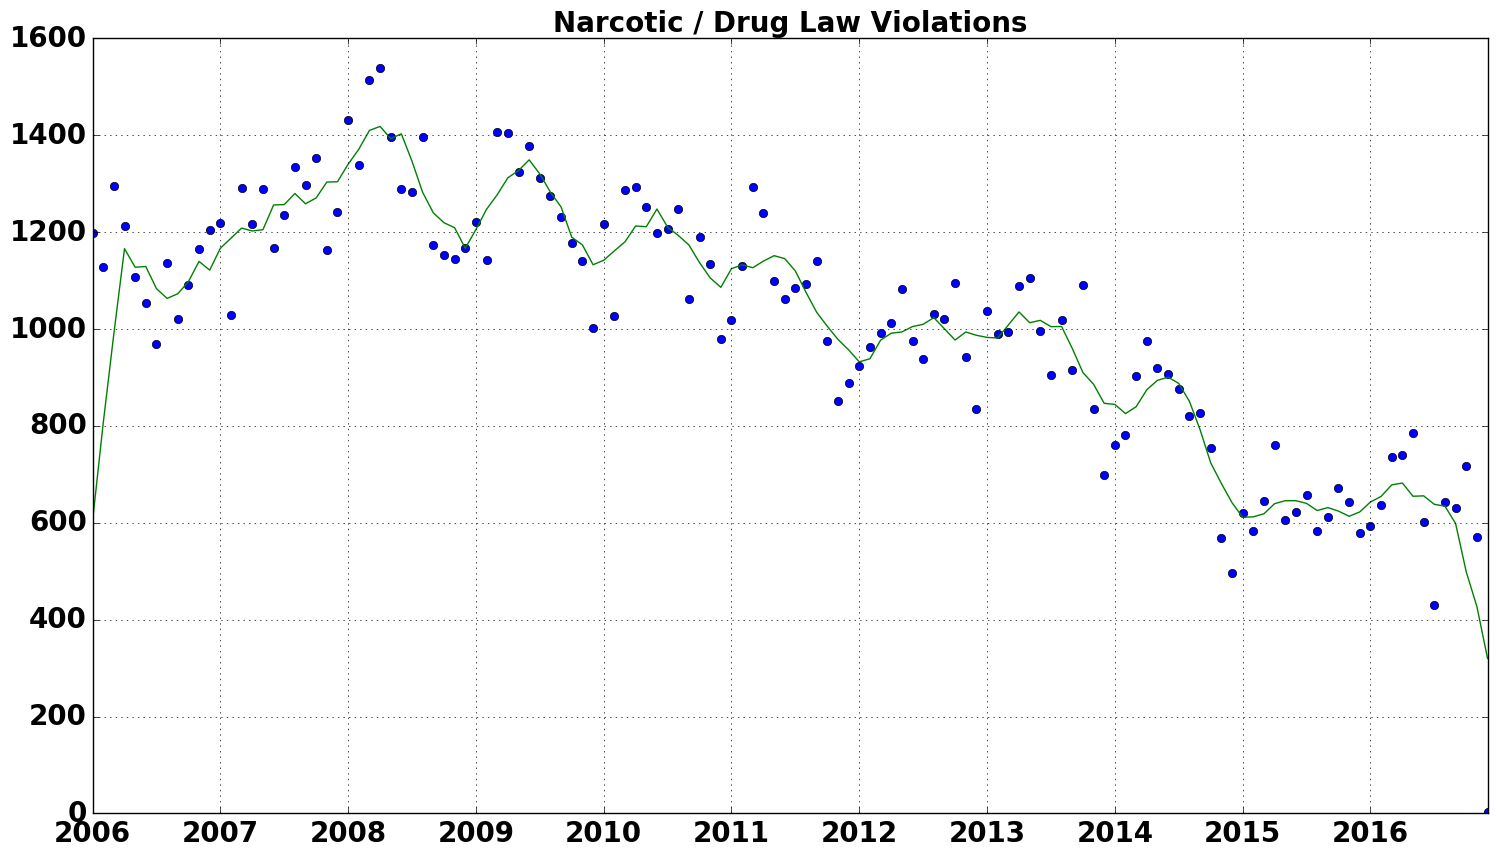

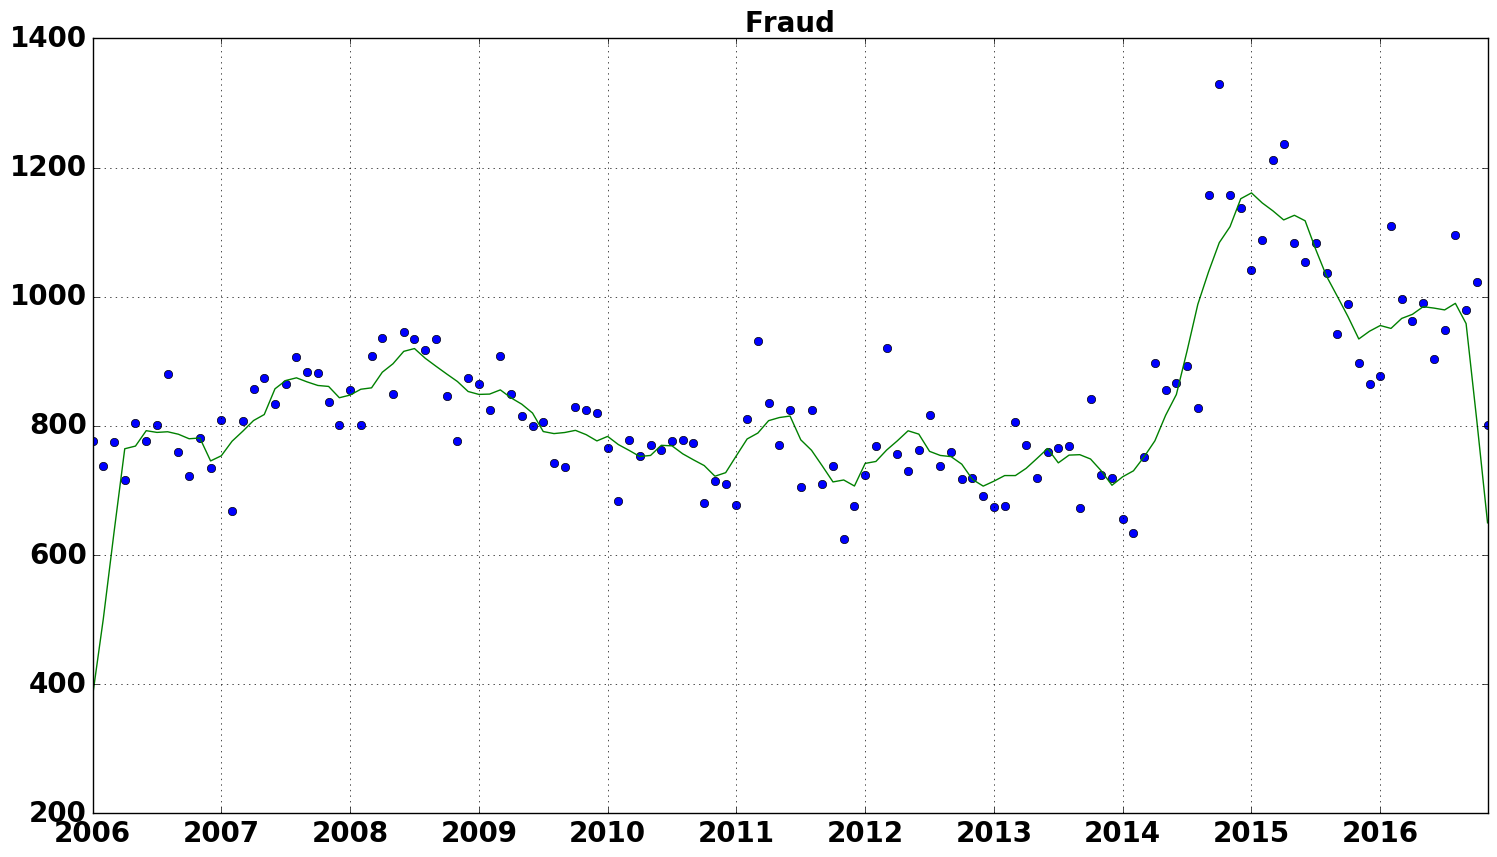

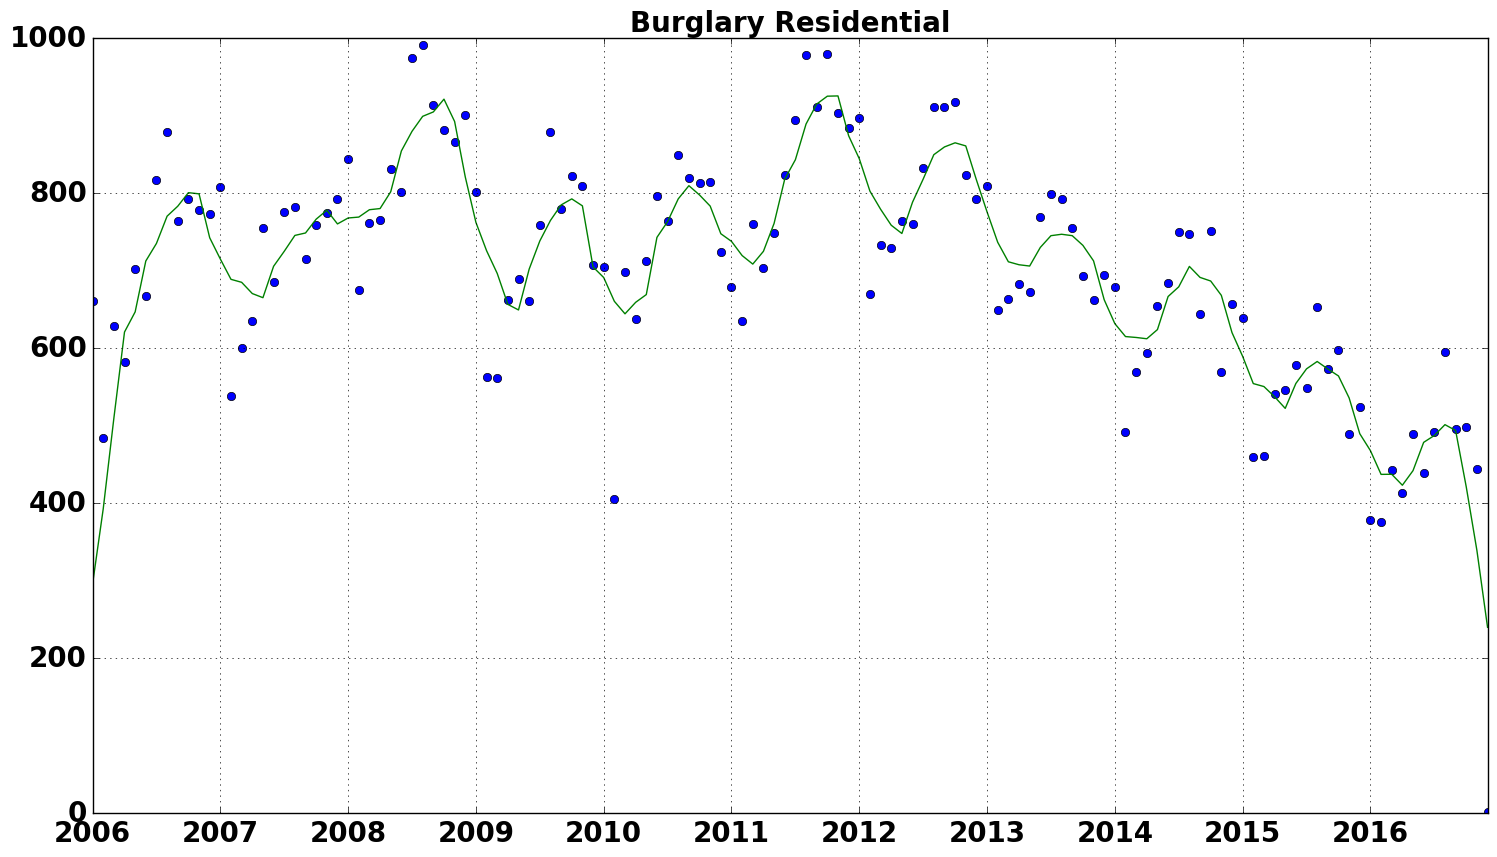

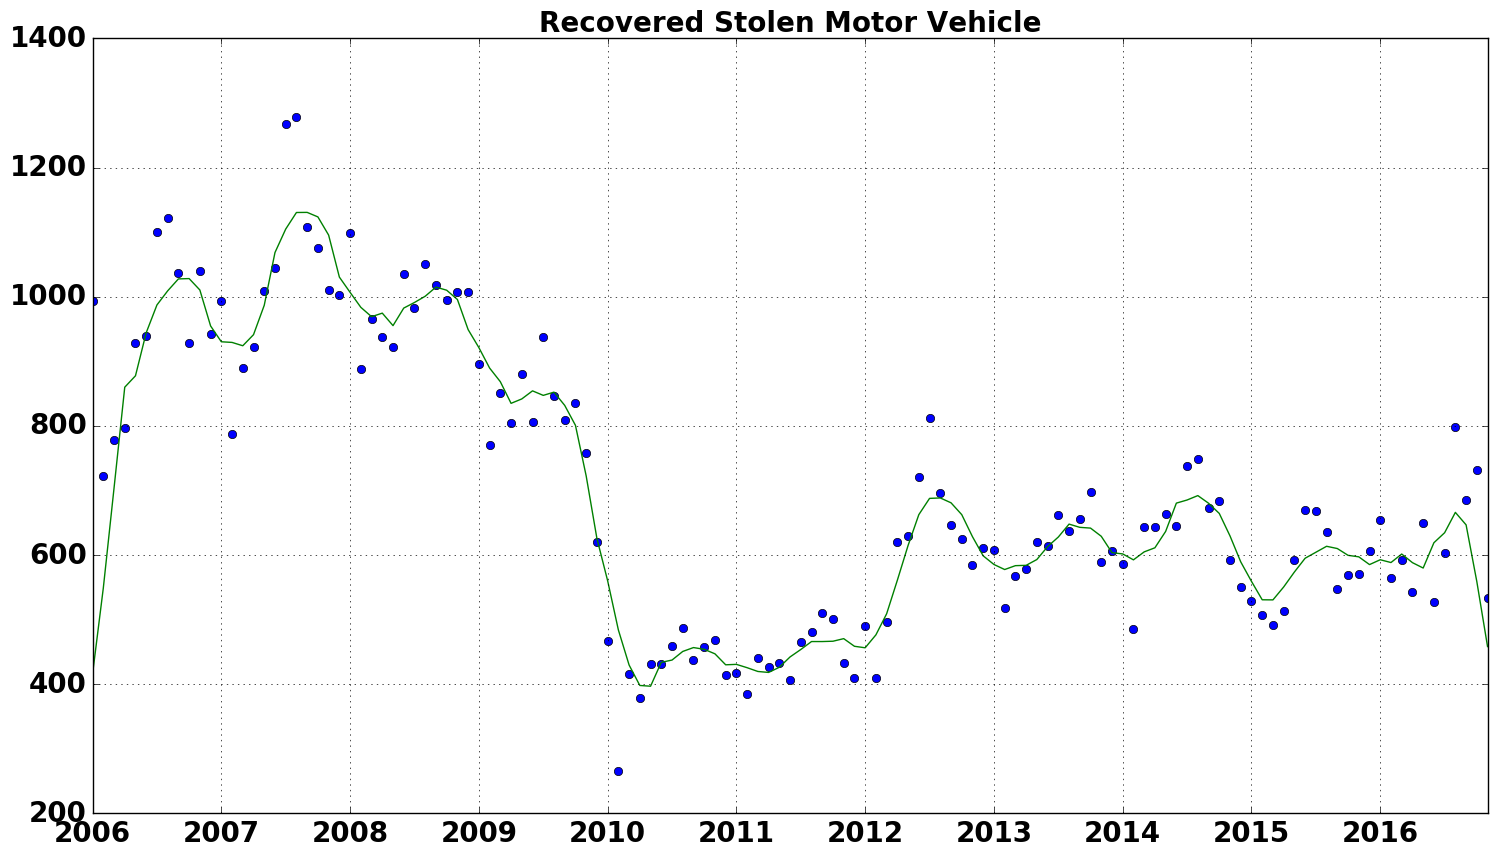

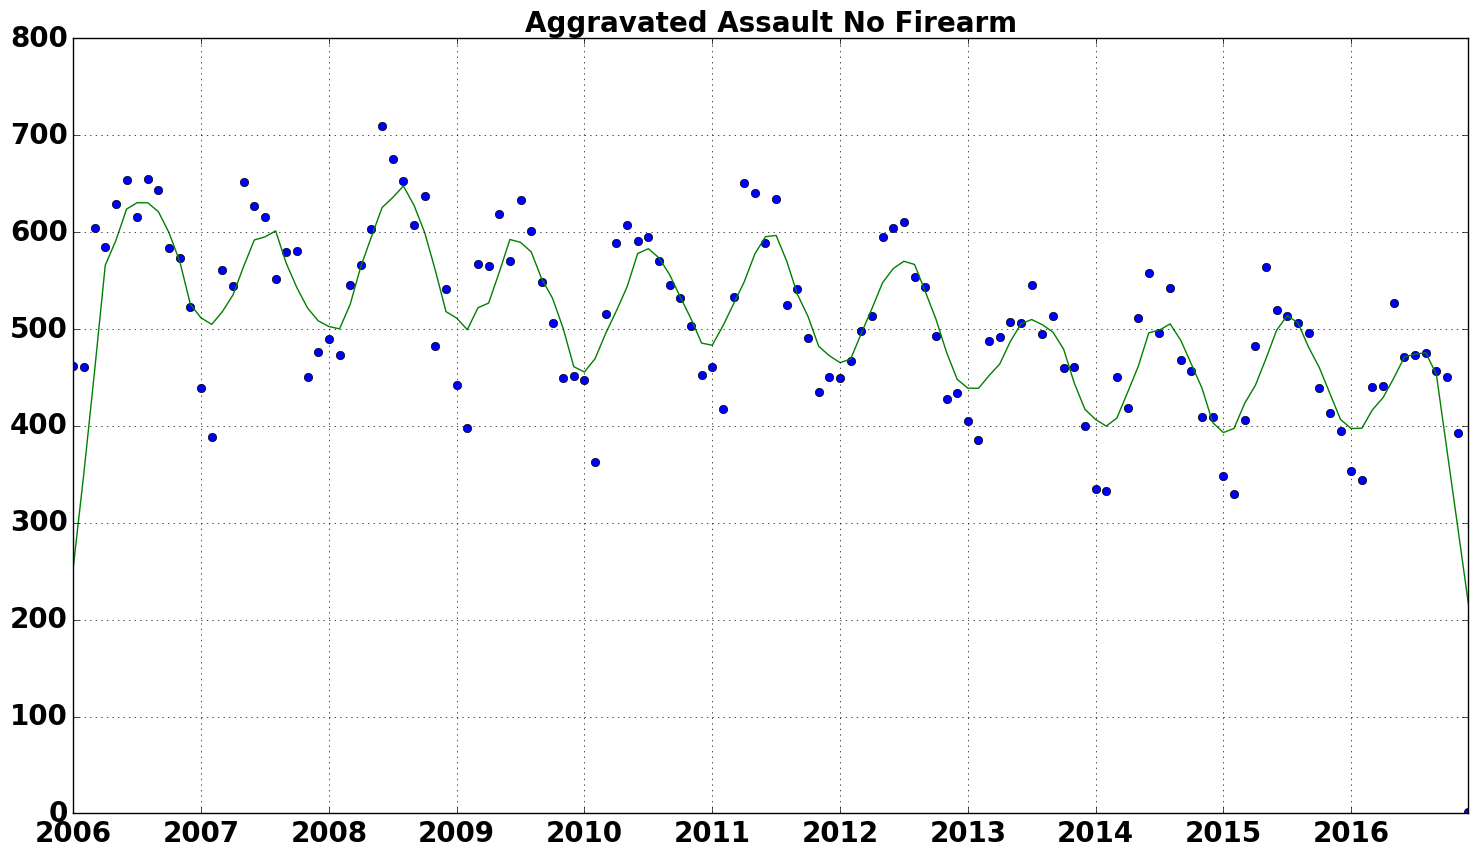

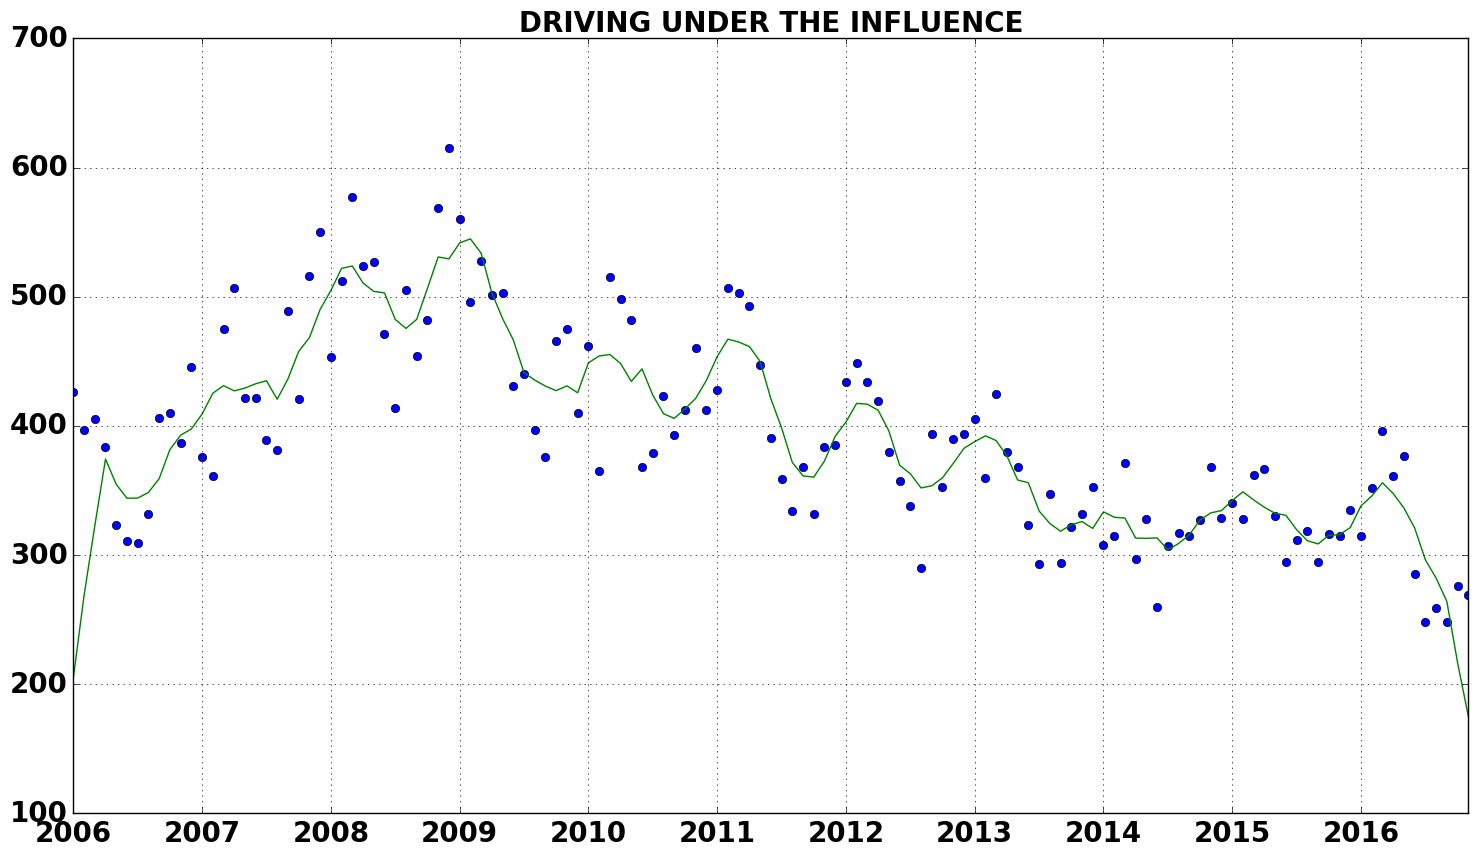

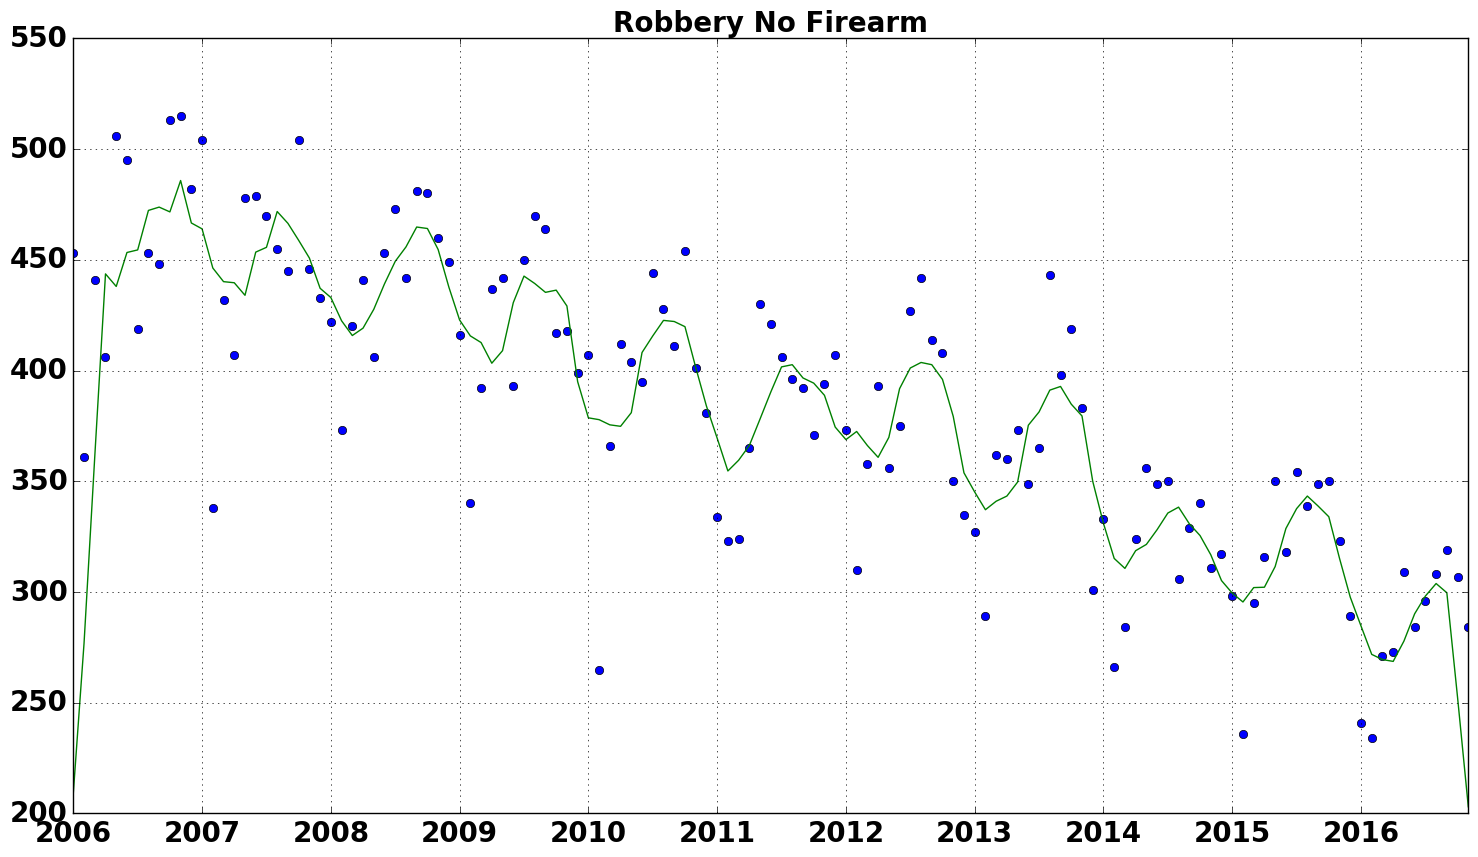

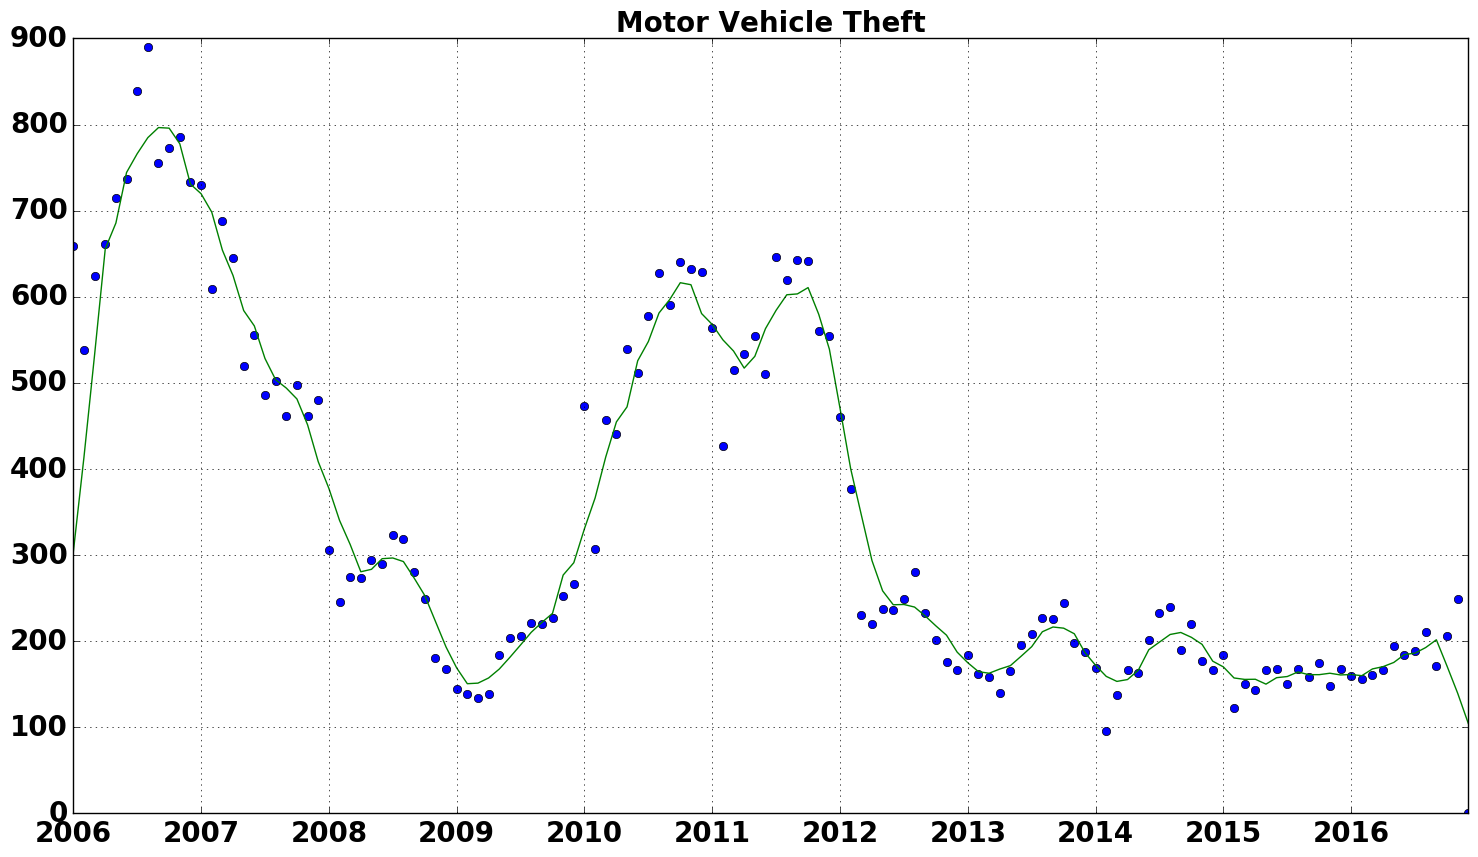

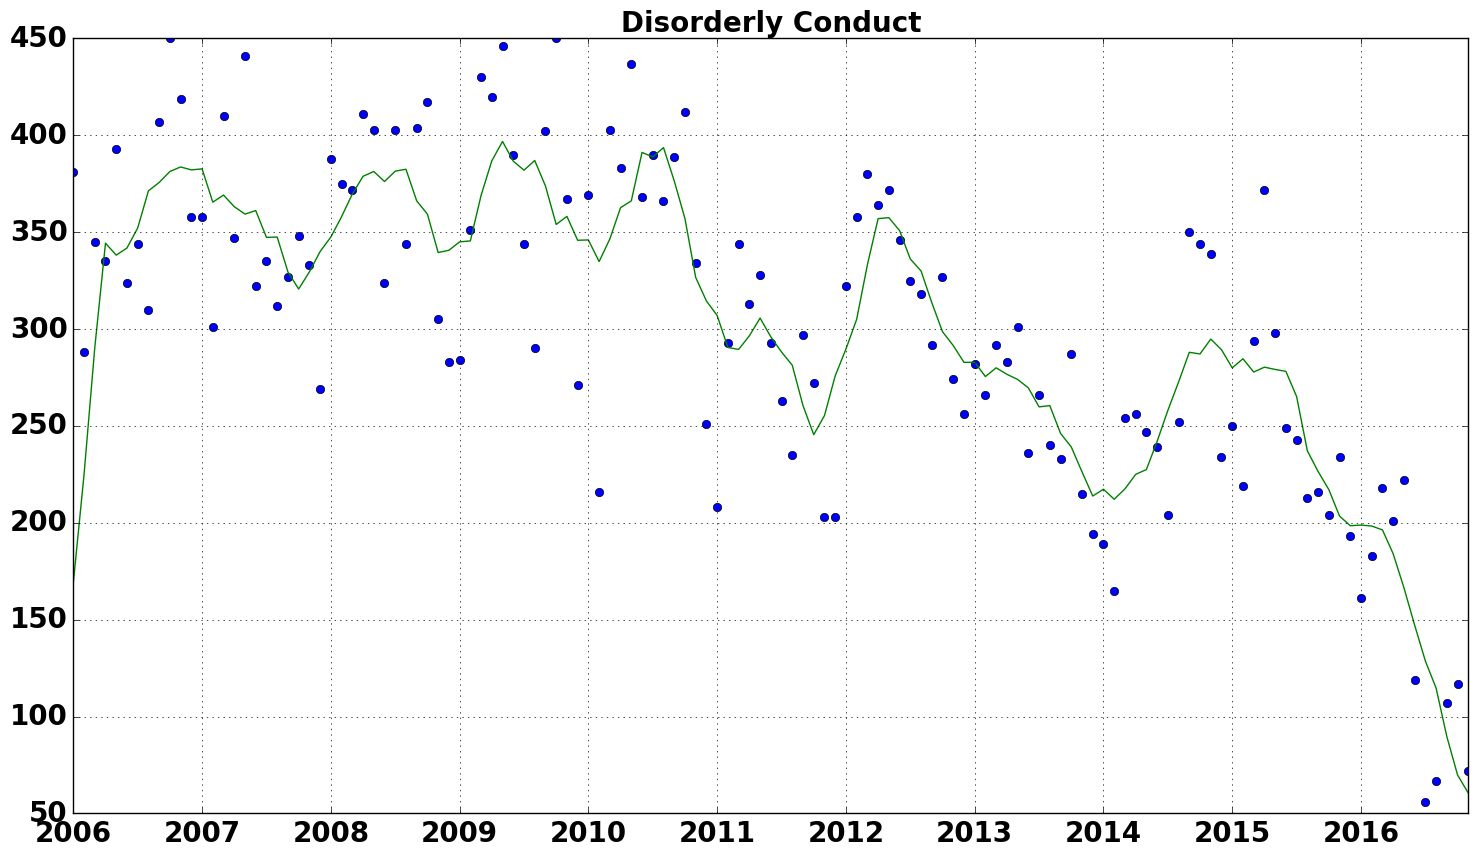

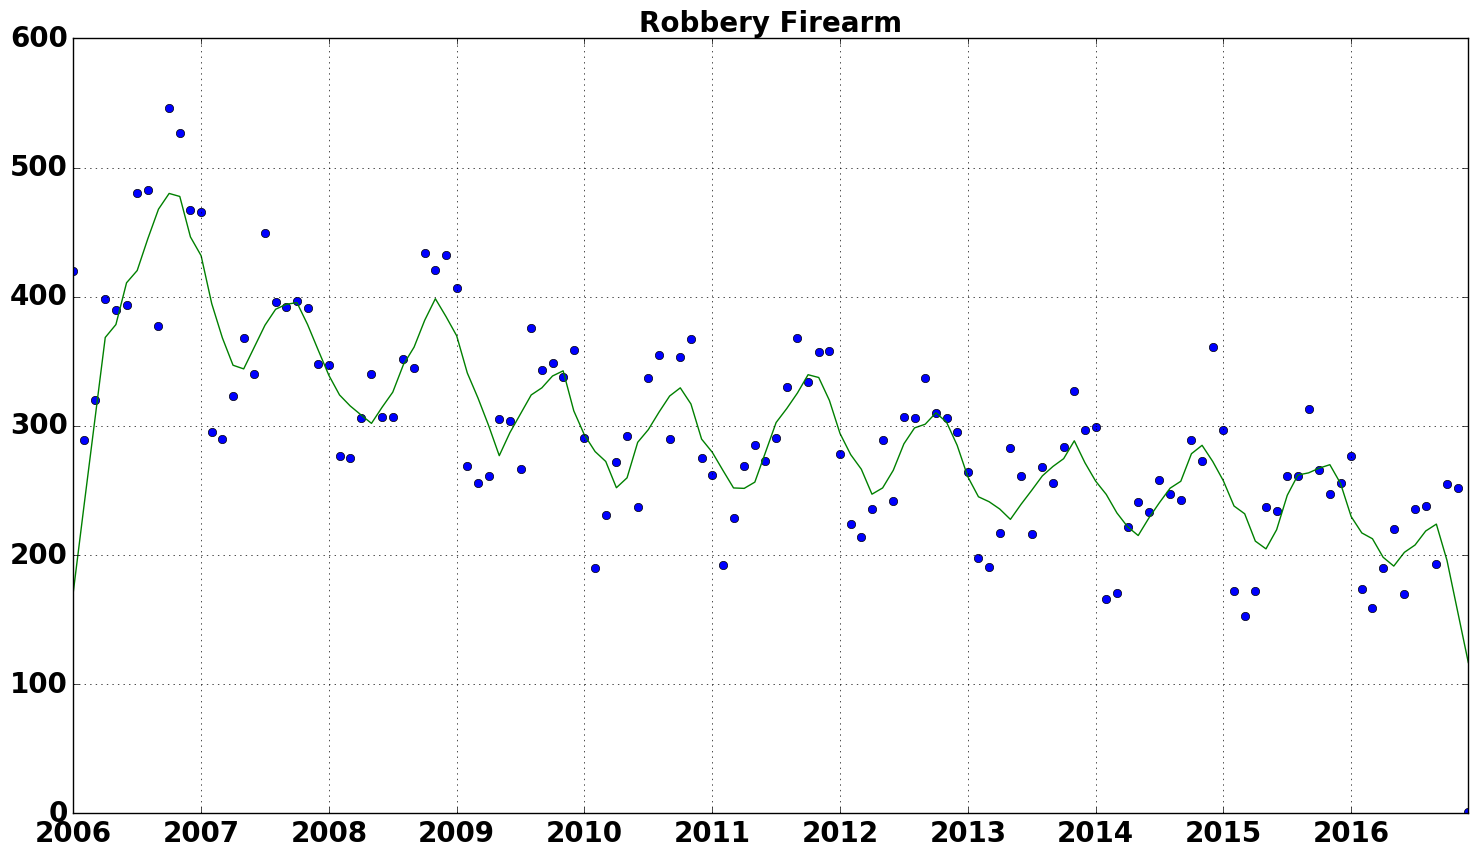

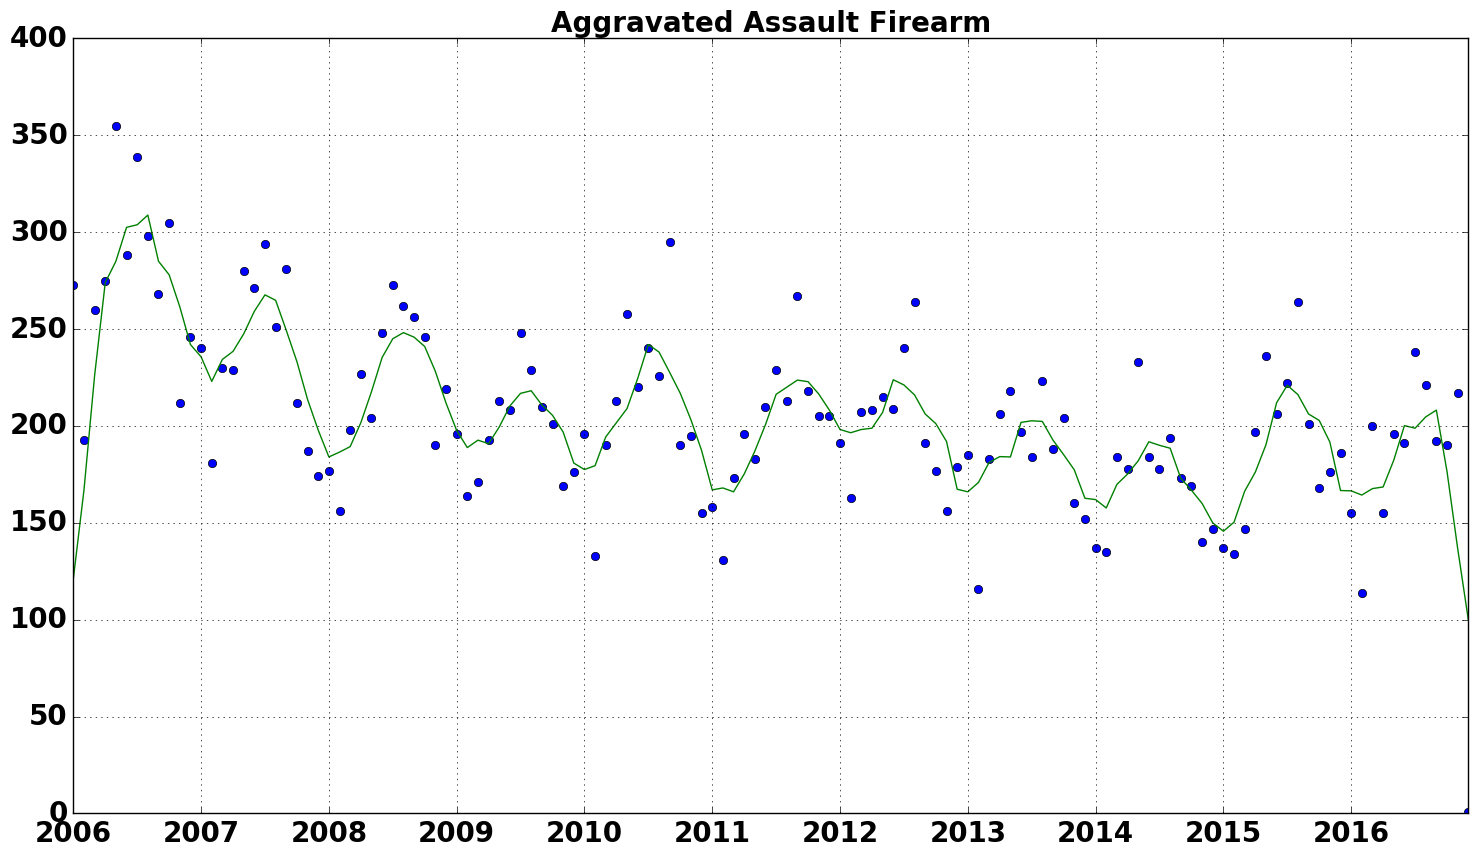

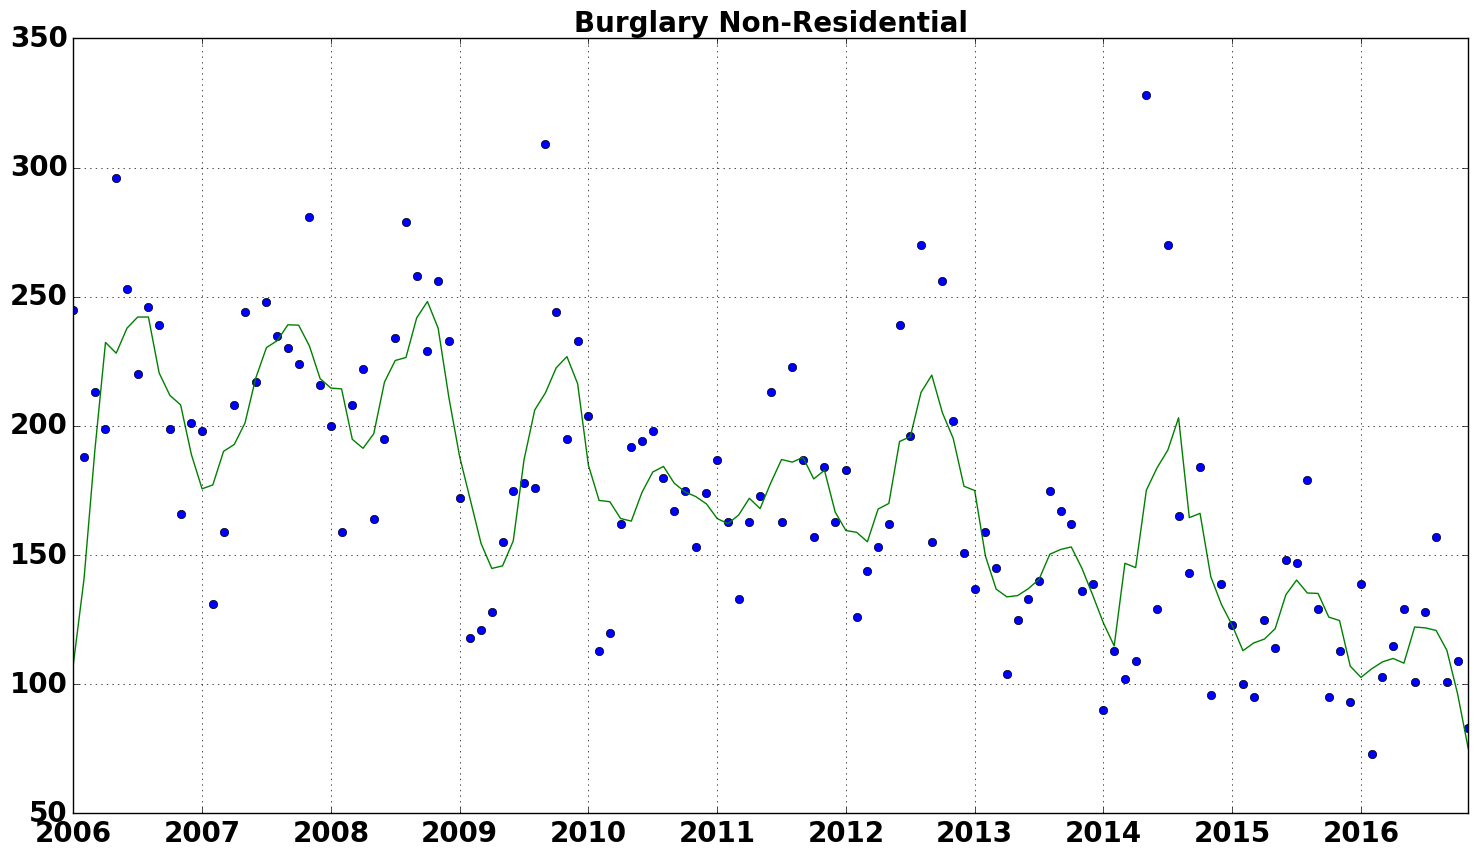

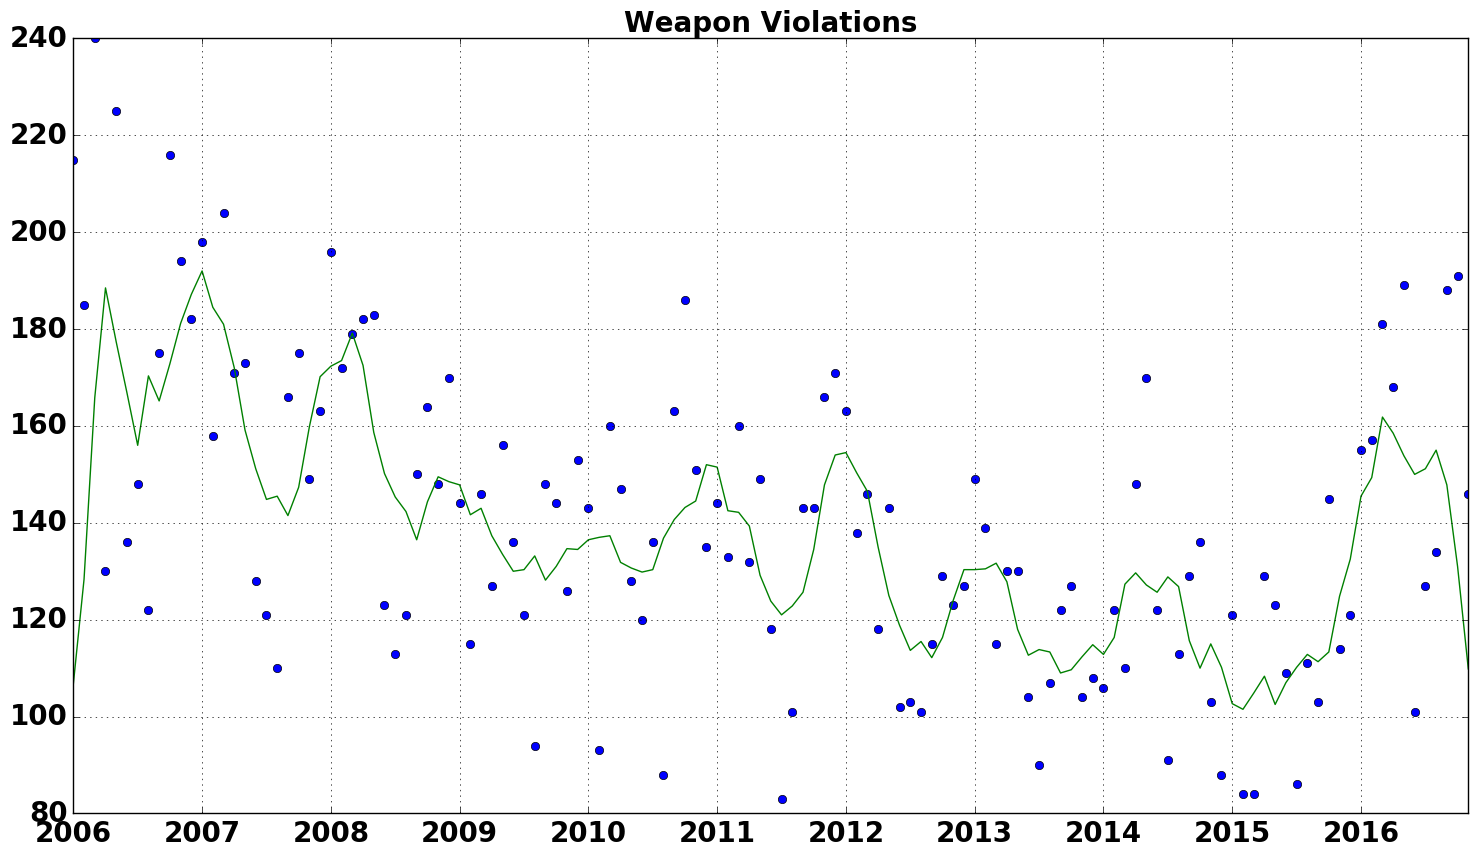

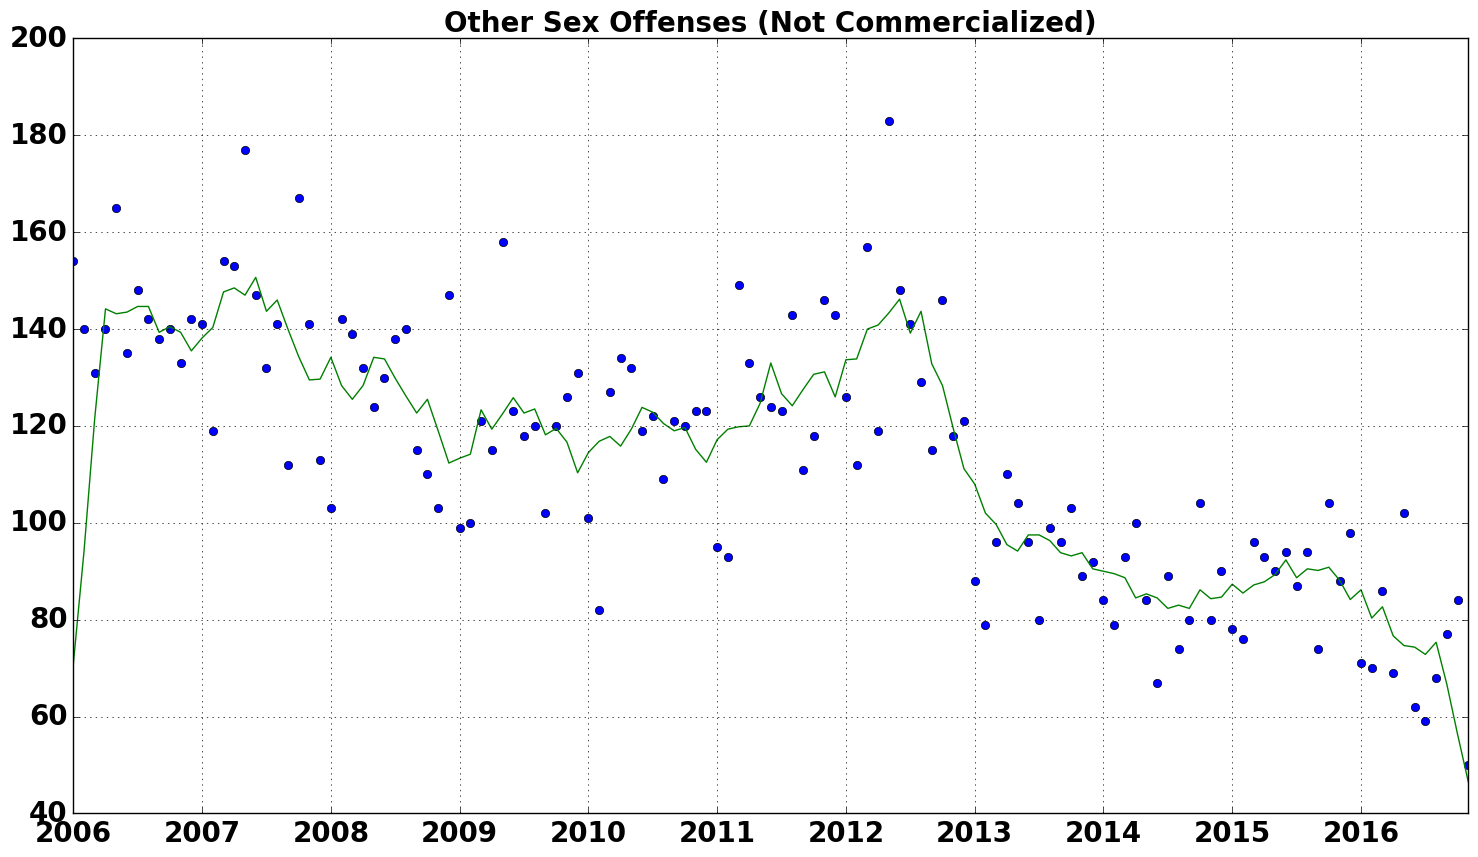

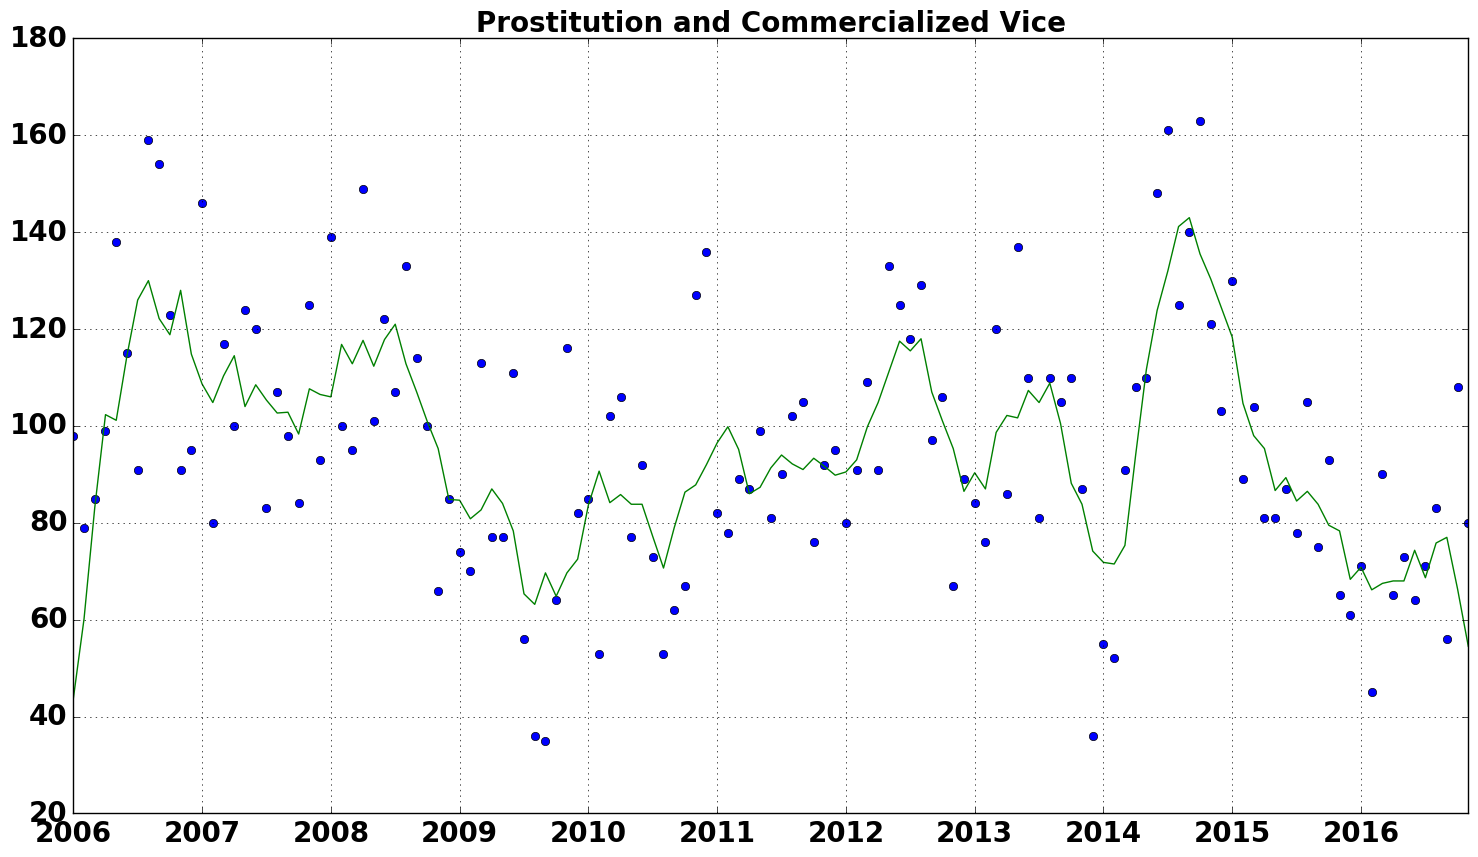

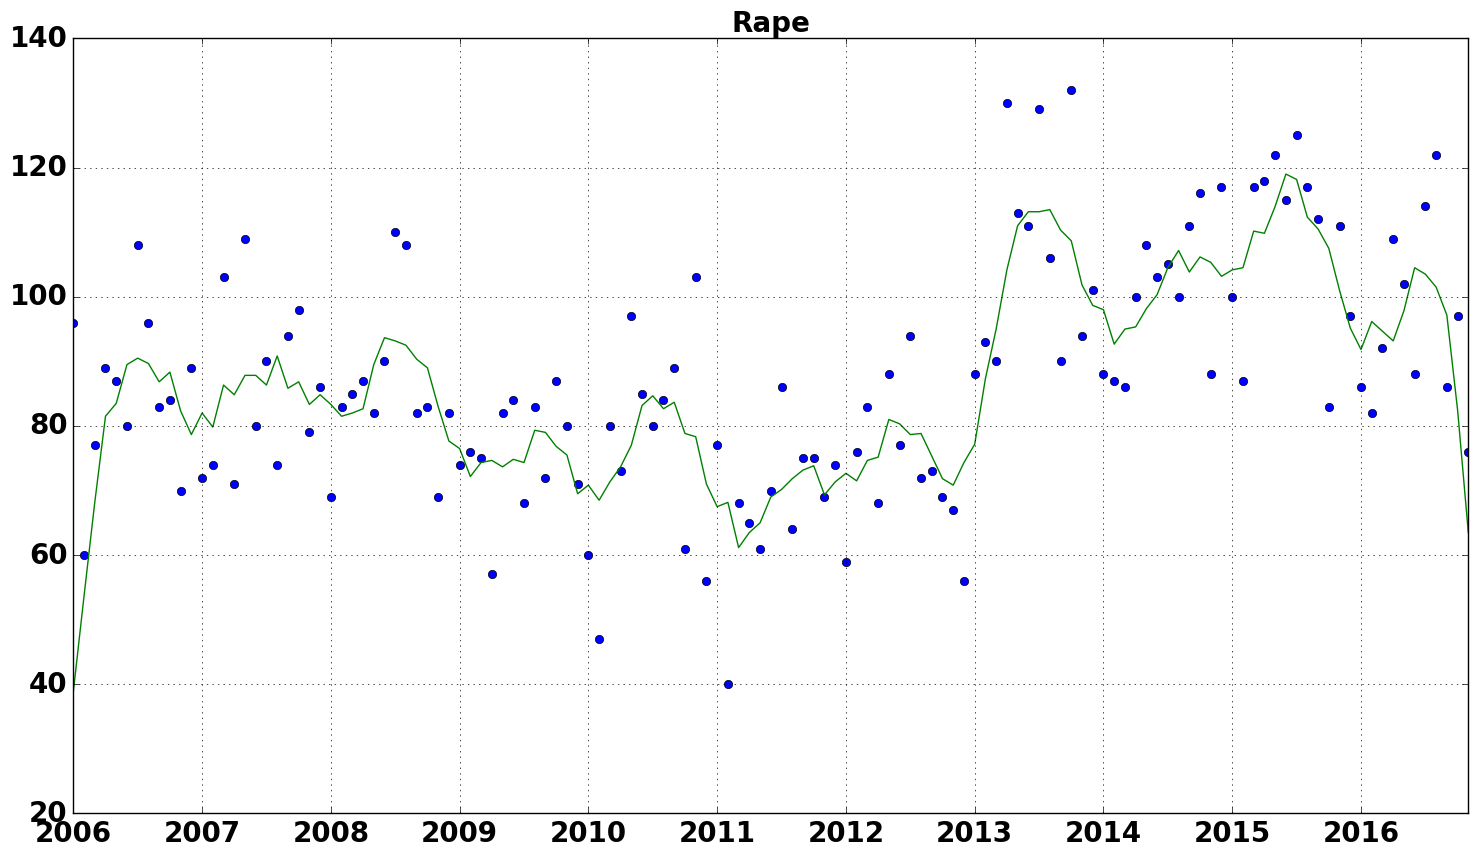

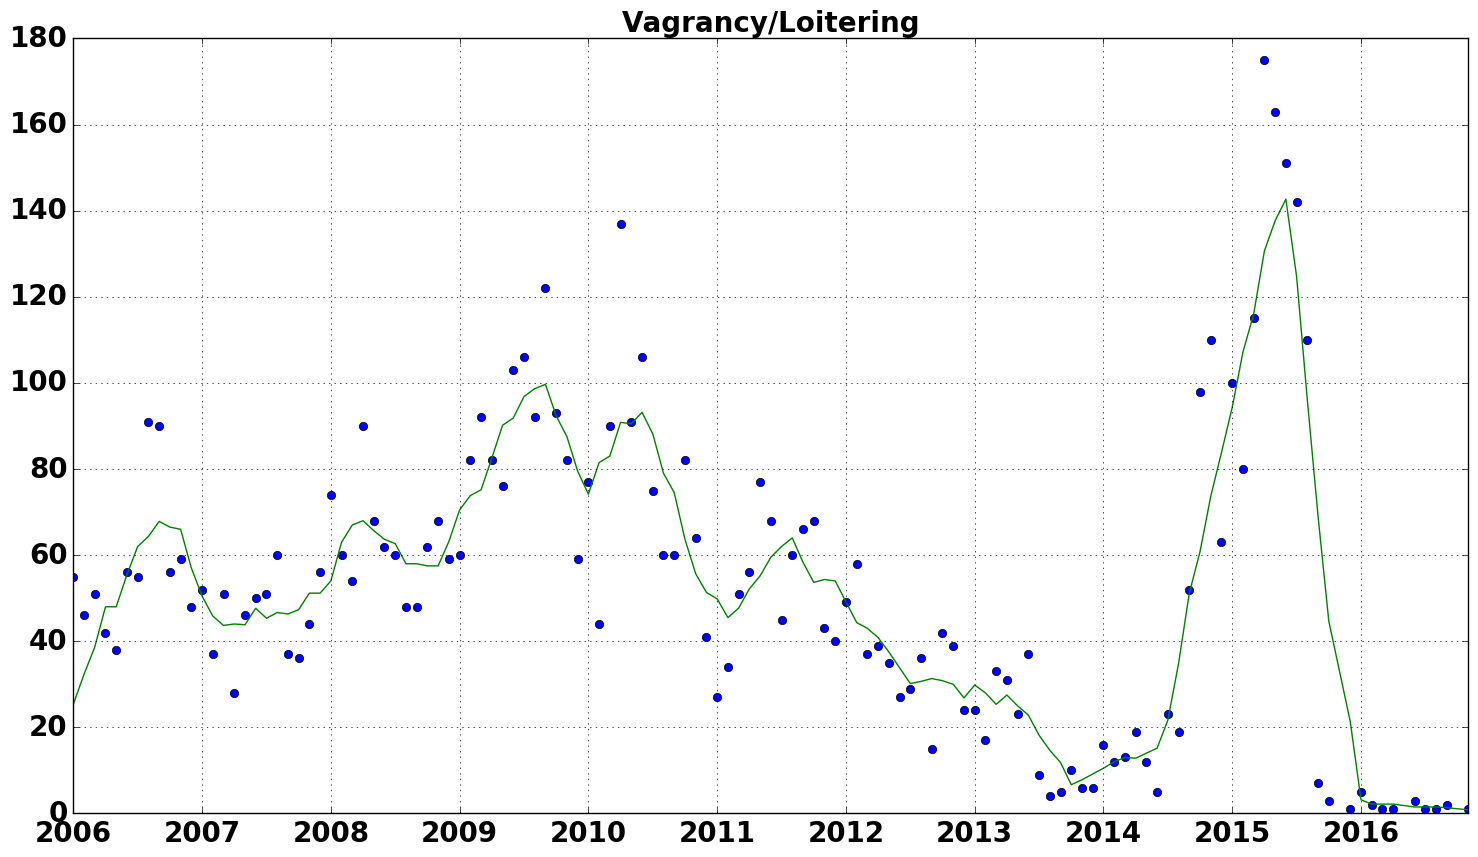

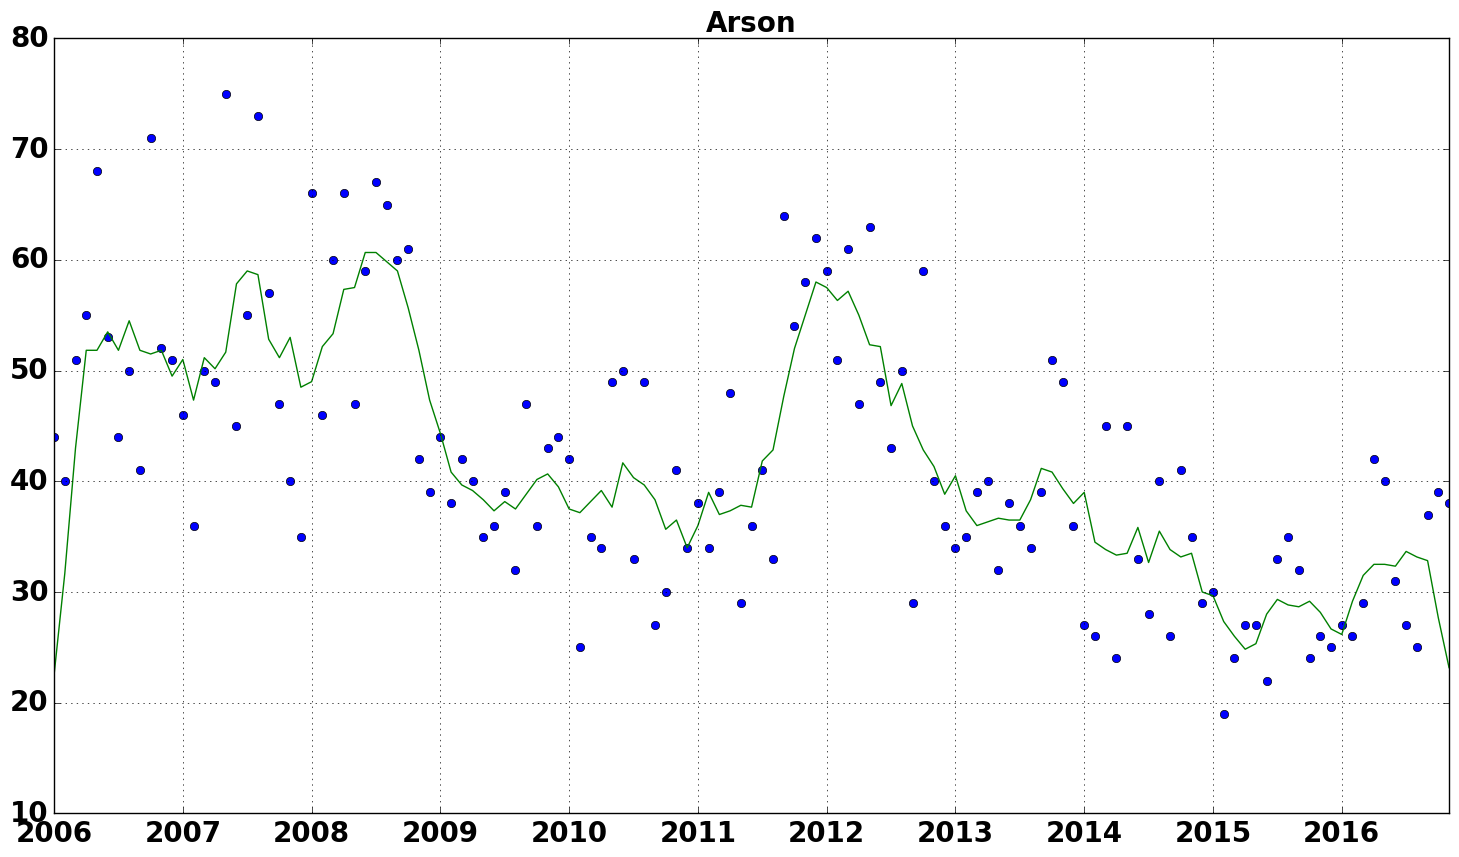

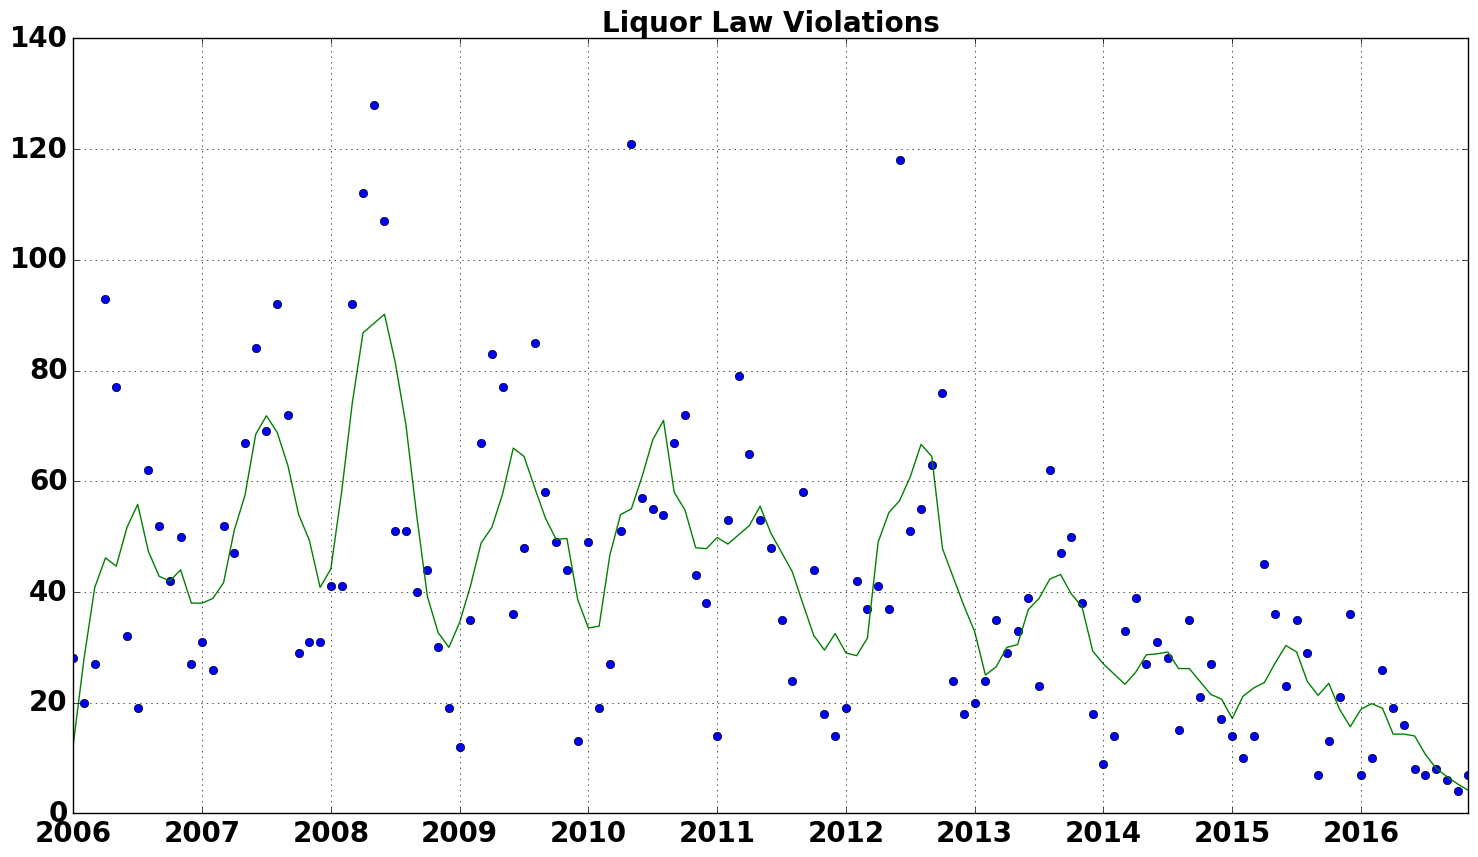

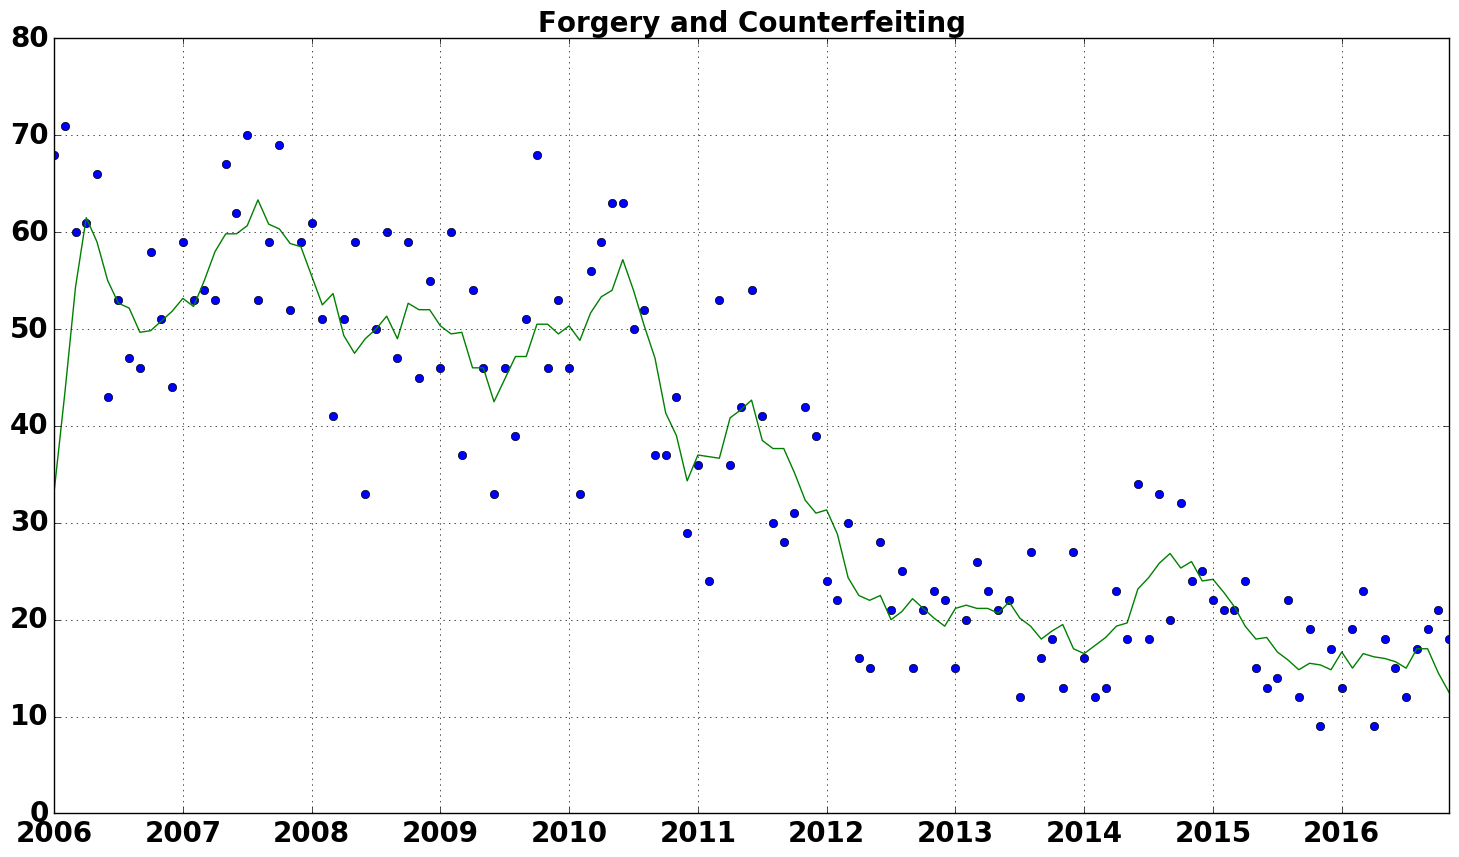

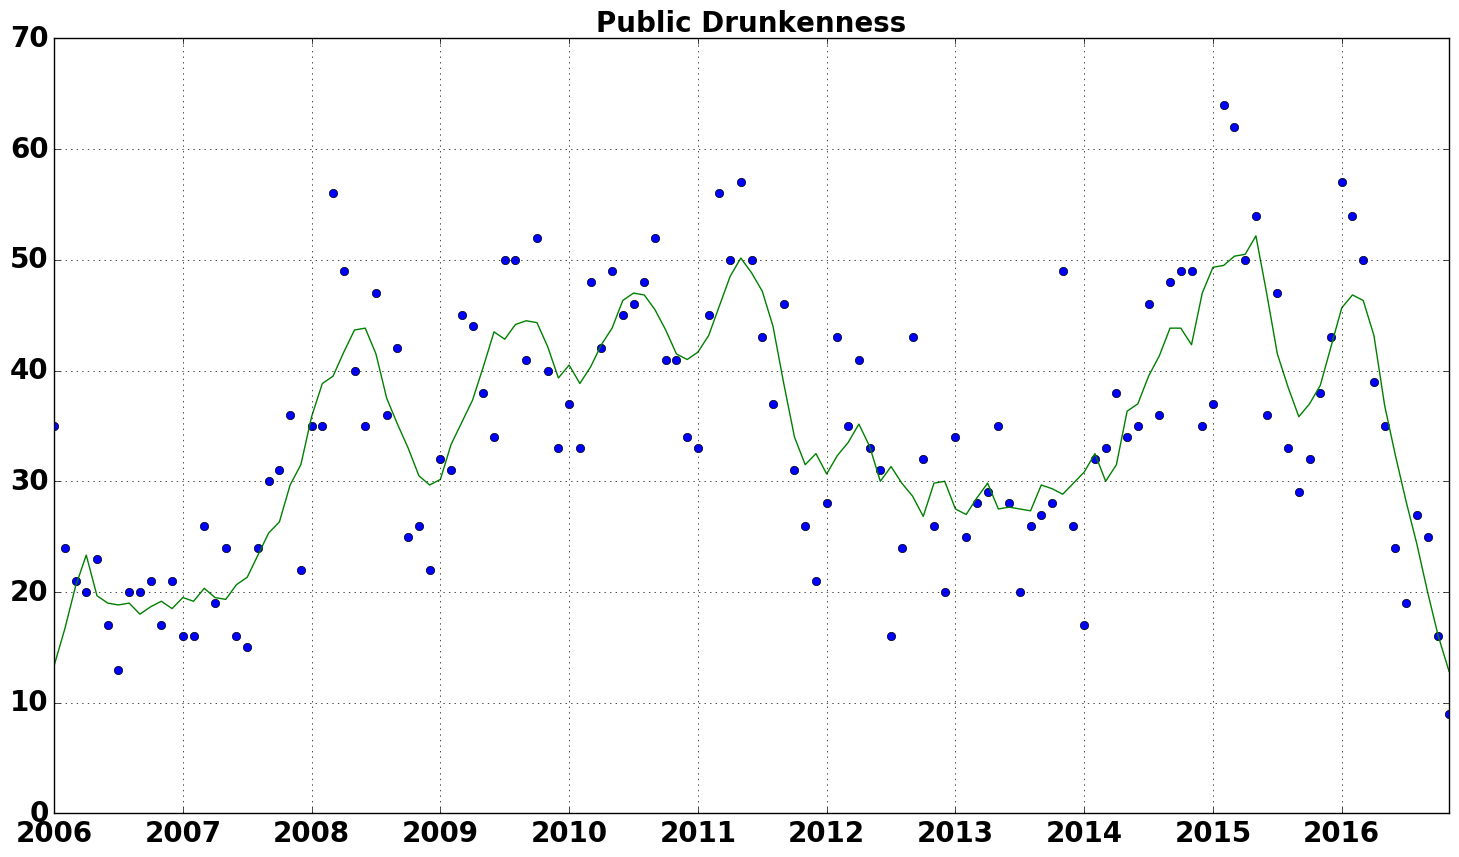

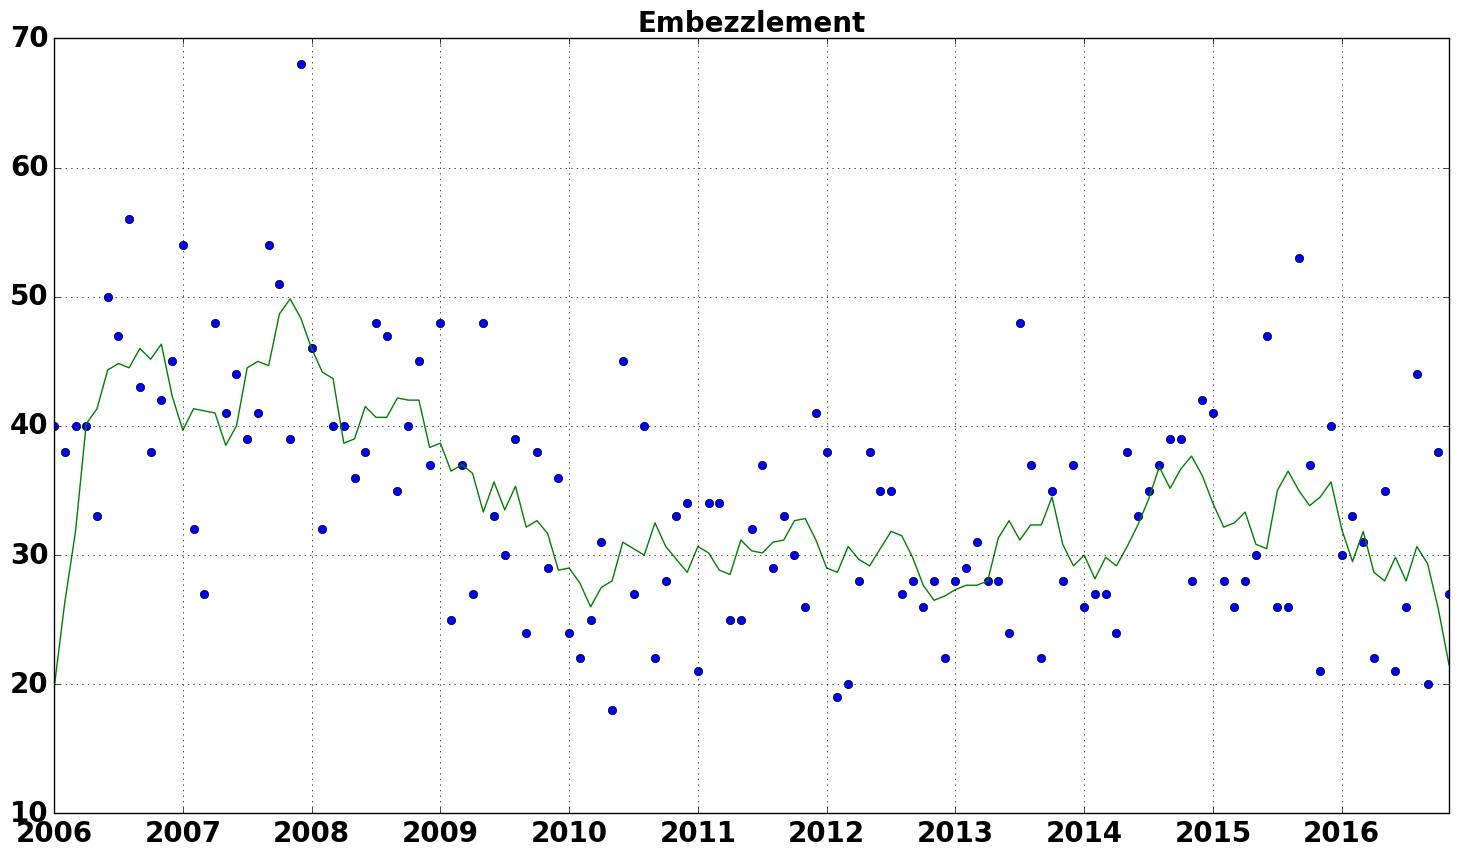

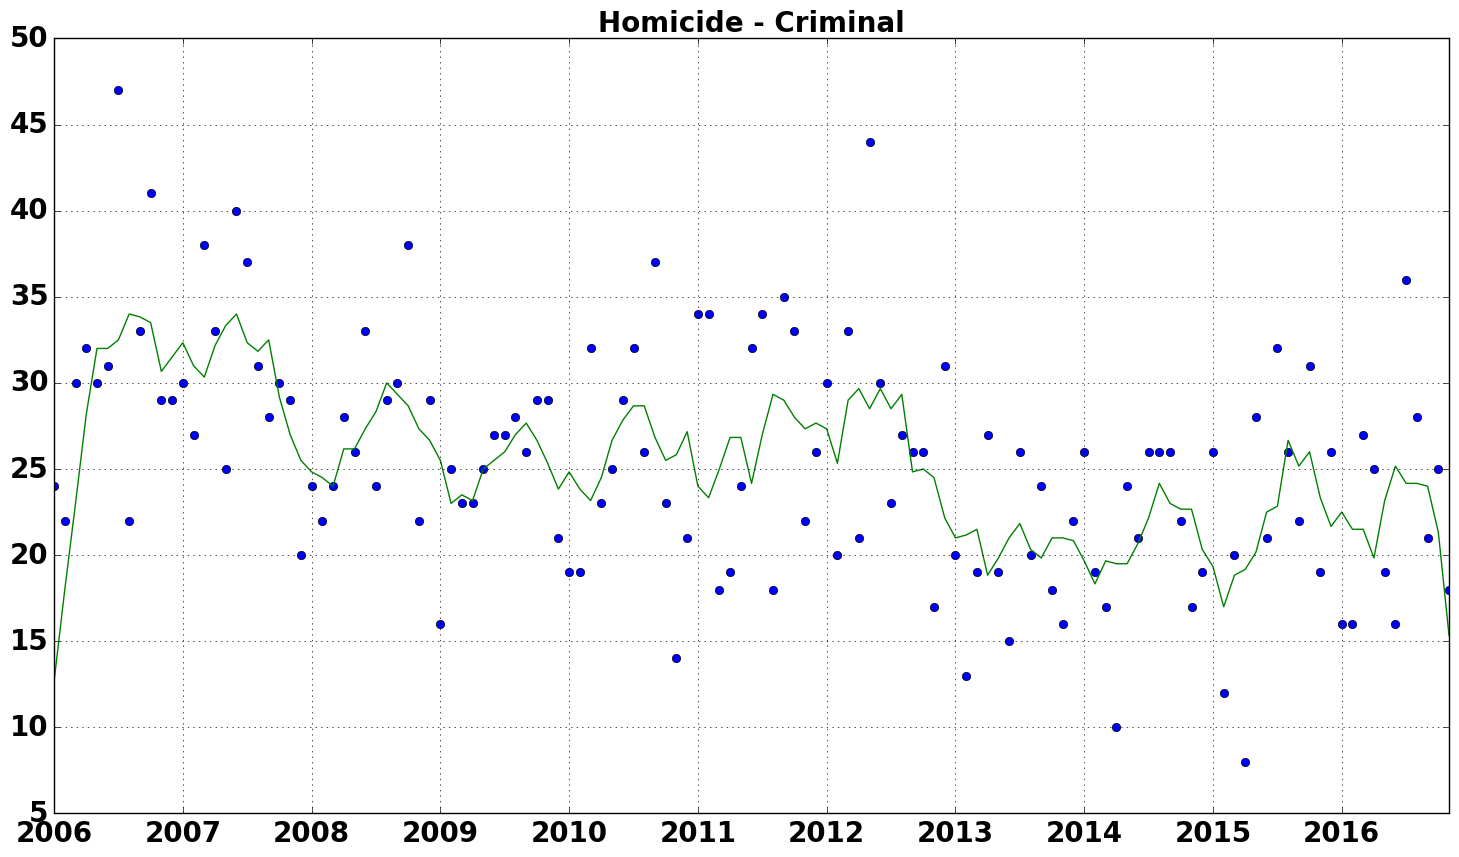

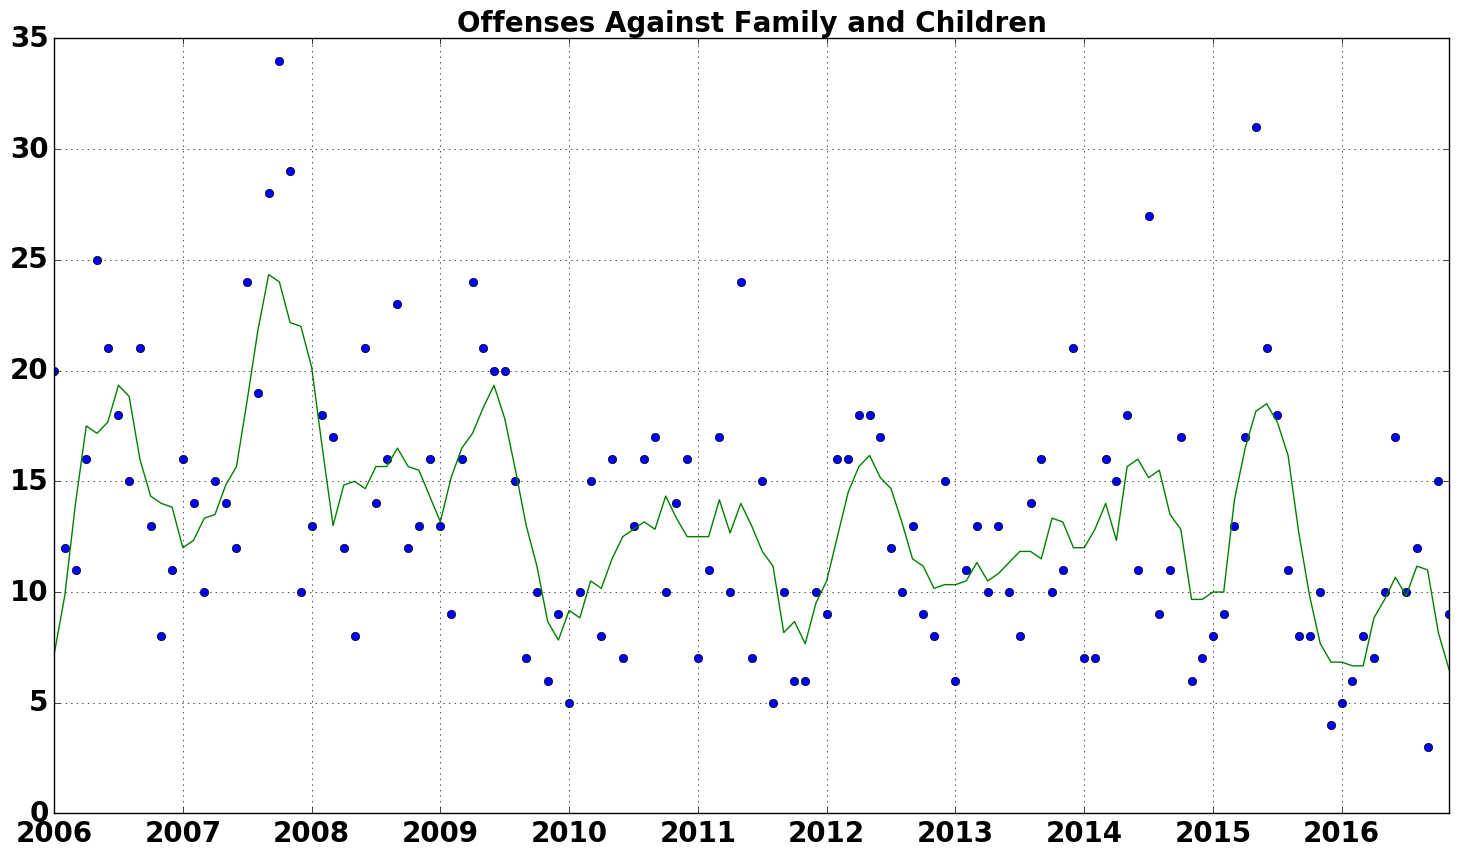

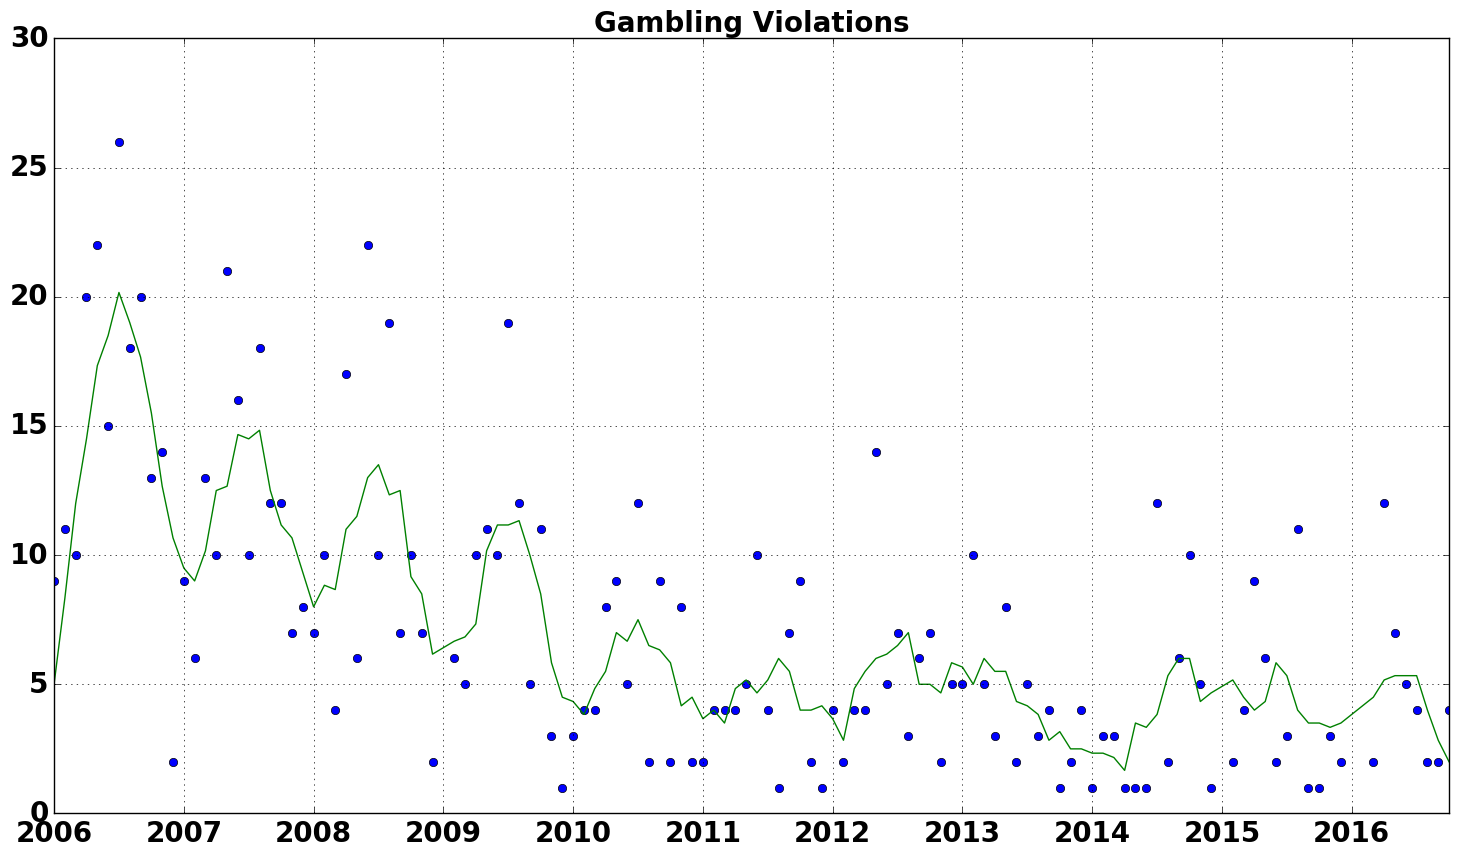

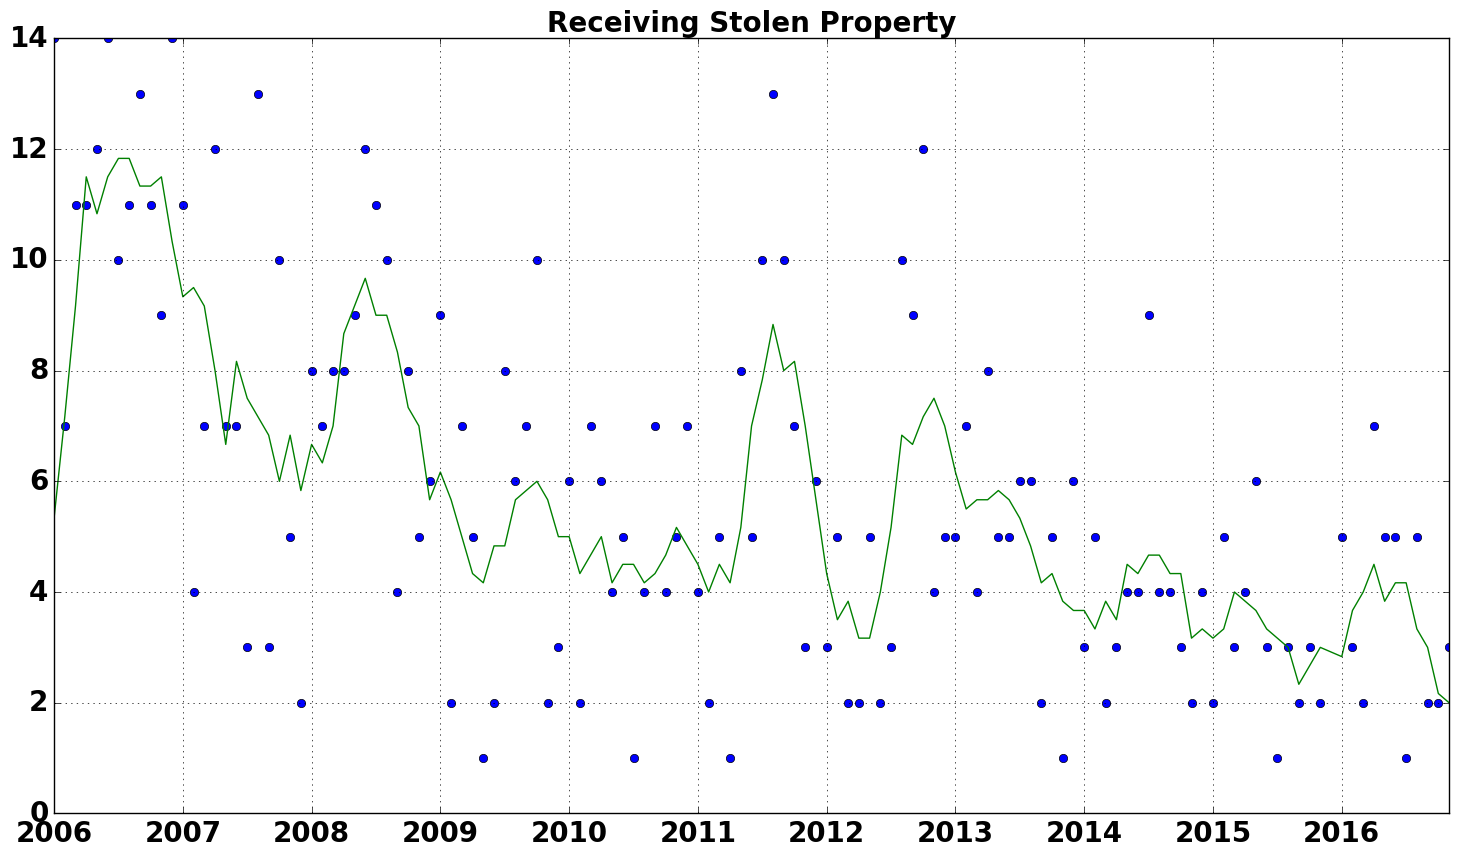

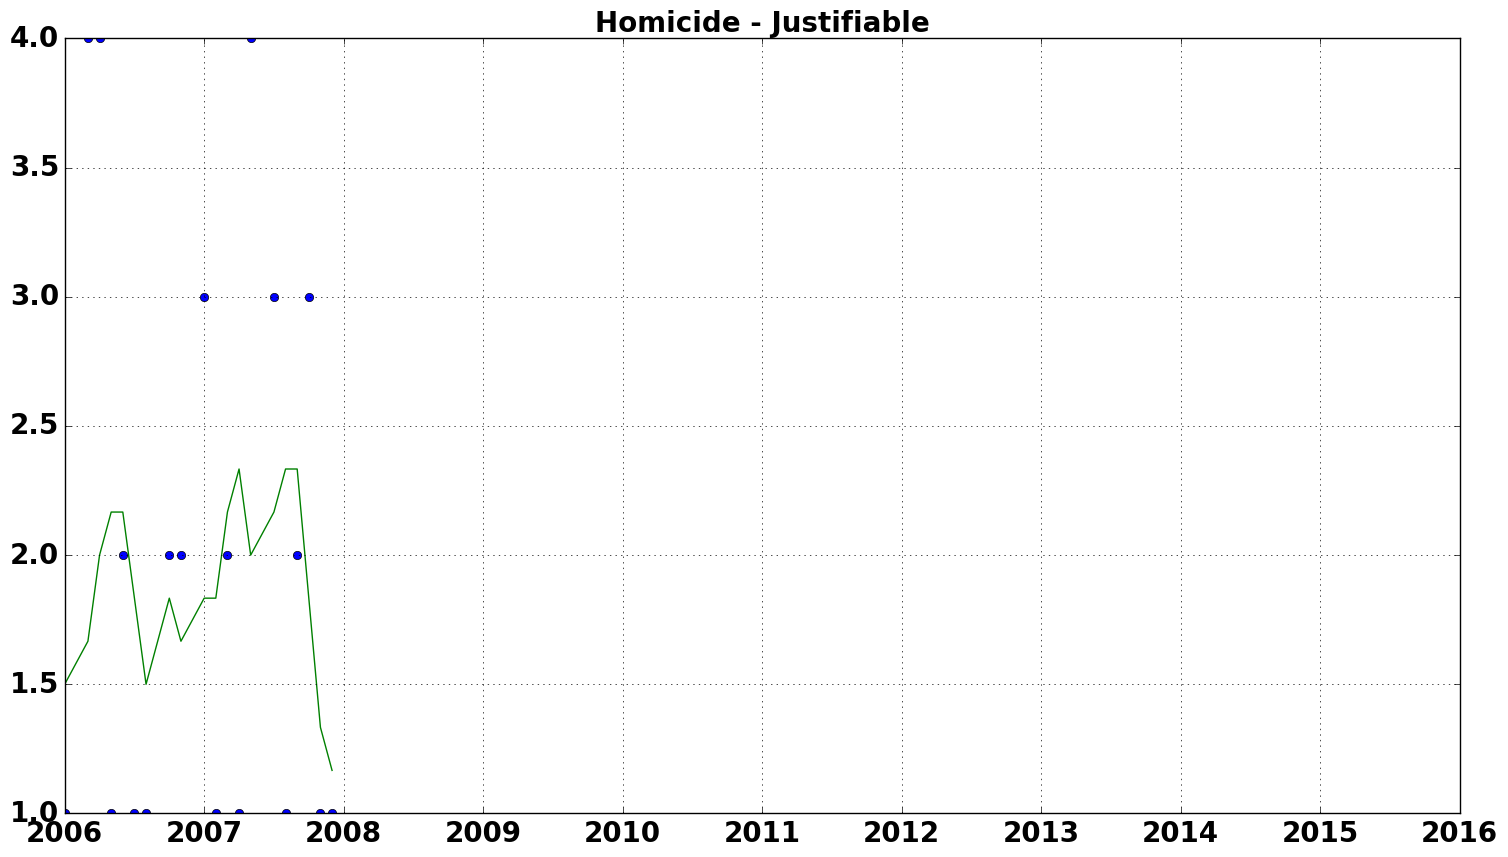

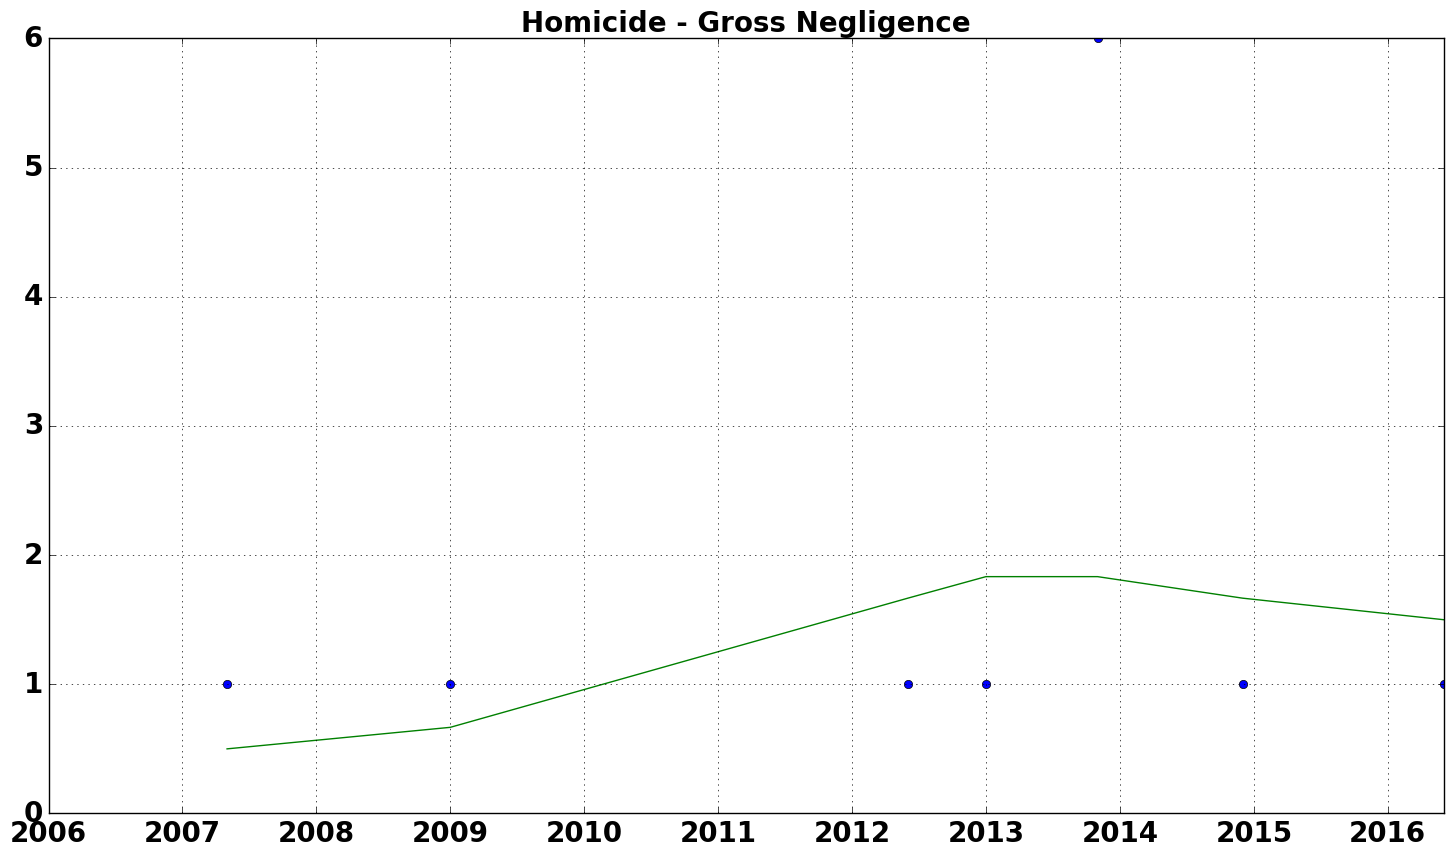

In [9]:
causes = DF.groupby('CAUSE')['COUNT'].count().sort_values(ascending=False).index

for i in causes:
    
    dummy_df = DF[DF['CAUSE']==i] 
    
    dummy_by_date = dummy_df.groupby('MTH_COUNT')['COUNT'].sum().reset_index()
    
    plt.figure(figsize=(18,10))
    
    plt.plot_date(dummy_by_date['MTH_COUNT'],dummy_by_date['COUNT'])
    plt.plot_date(dummy_by_date['MTH_COUNT'], movingaverage(dummy_by_date['COUNT'],6),'-')
    
    plt.title('%s' %i, **text_opts)
    plt.xticks(np.arange(xmin,xmax+1,12), np.arange((interval), dtype=int)+2006, **text_opts)
    plt.yticks(**text_opts)
    plt.grid()
